<center><h1>Books sales Forecasting using Temporal Fusion Transformer</h1></center>

In this notebook, we will be training and testing a Temporal Fusion Transformer (TFT) on Kaggle's Tabular playground competition (Sept 2022) dataset. The dataset contains the total number of daily sales of 4 books from two stores located in six different countries. We have training data for over 3 years from 2017 to 2020. The goal is to predict the number of sales for 2021 for each book in each store and in each country.
> Link : https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/overview

For the implementation of the TFT model, we will use the open source Pytorch Forecasting python package. You can install it using pip:

```console
$ pip install pytorch-forecasting
```

Pytorch Forecasting is based on Pytorch Lightning and integrates Optuna for hyperparameter tuning. A tutorial about about how to use Pytorch Forecasting's TFT is available in the tutorial: https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

In [45]:
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd

from scipy import signal
import seaborn as sns

from pathlib import Path

import holidays

import pickle

import torch

#sys.path.append("..")

In [46]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [47]:
import pandas as pd

def check_na(df):
    """
    percentage of rows containing NaN data
    """
    return df.isna().sum() * 100 / len(df)

def get_missing_dates(df, freq= None, start_date=None, end_date=None):
    """
    get dates which are missing in the series
    """
    if start_date is None:
        start_date = df.index[0]

    if end_date is None:
        end_date = df.index[-1]

    if freq is None:
        freq = df.index.freq

    return pd.date_range(start=start_date, end=end_date, freq=freq).difference(df.index)

from typing import List, Union
import numpy as np
import pandas as pd

CALENDAR_CYCLES = {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

def add_cyclical_calendar_features(df: pd.DataFrame, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features
    NOTE datetime column must be set as index """

    if isinstance(features, str):
        features = [features]

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"
       
        values = getattr(df.index, feat)
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df

In [48]:
SAVE_DIR = './models'
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

### Load data

In [49]:
DATAPATH = Path("./")

In [50]:
train_df = pd.read_csv(DATAPATH / "train.csv")
train_df['date']  = pd.to_datetime(train_df['date'])
train_df

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [51]:
test_df = pd.read_csv(DATAPATH / "test.csv")
test_df['date']  = pd.to_datetime(test_df['date'])
test_df

row_id       date  country       store  \
0       70128 2021-01-01  Belgium  KaggleMart   
1       70129 2021-01-01  Belgium  KaggleMart   
2       70130 2021-01-01  Belgium  KaggleMart   
3       70131 2021-01-01  Belgium  KaggleMart   
4       70132 2021-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
17515   87643 2021-12-31    Spain  KaggleMart   
17516   87644 2021-12-31    Spain  KaggleRama   
17517   87645 2021-12-31    Spain  KaggleRama   
17518   87646 2021-12-31    Spain  KaggleRama   
17519   87647 2021-12-31    Spain  KaggleRama   

                                product  
0            Kaggle Advanced Techniques  
1                Kaggle Getting Started  
2                    Kaggle Recipe Book  
3      Kaggle for Kids: One Smart Goose  
4            Kaggle Advanced Techniques  
...                                 ...  
17515  Kaggle for Kids: One Smart Goose  
17516        Kaggle Advanced Techniques  
17517            Kaggle Getting Started  
17518                Kaggle Recipe Book  
17519  Kaggle for Kids: One Smart Goose  

[17520 rows x 5 columns]

In [52]:
check_na(train_df)

row_id      0.0
date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64

In [53]:
get_missing_dates(train_df.set_index("date"))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## Data exploration

We take a first look on the data

Text(0.5, 1.0, 'sum of num_sold per product ')

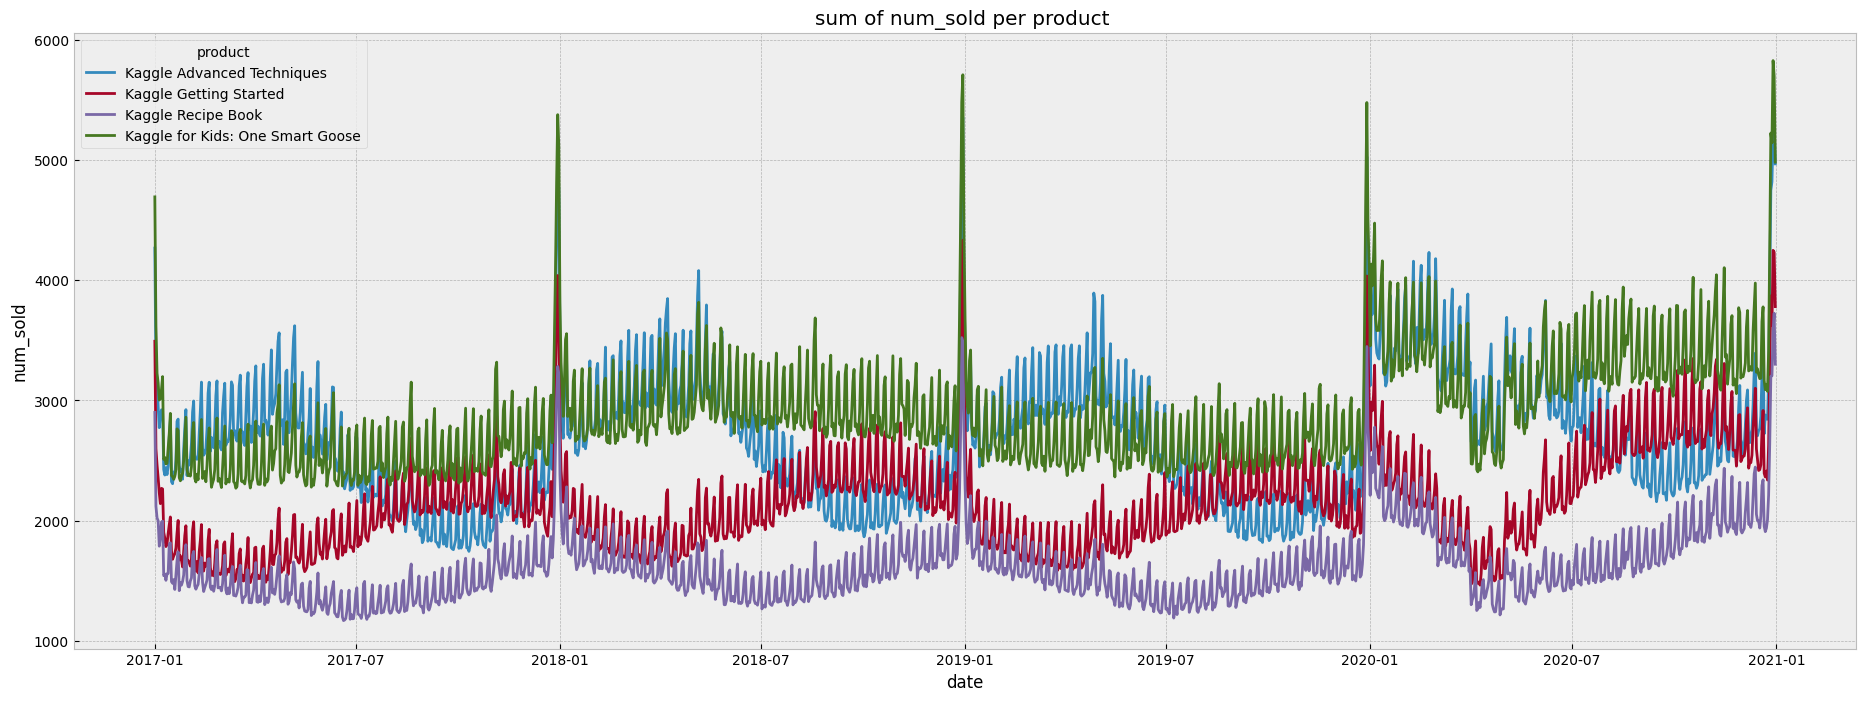

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='product',data=(train_df.groupby(['date', 'product']).num_sold.sum().to_frame()))
ax.set_title("sum of num_sold per product ")

Text(0.5, 1.0, 'sum of num_sold per store ')

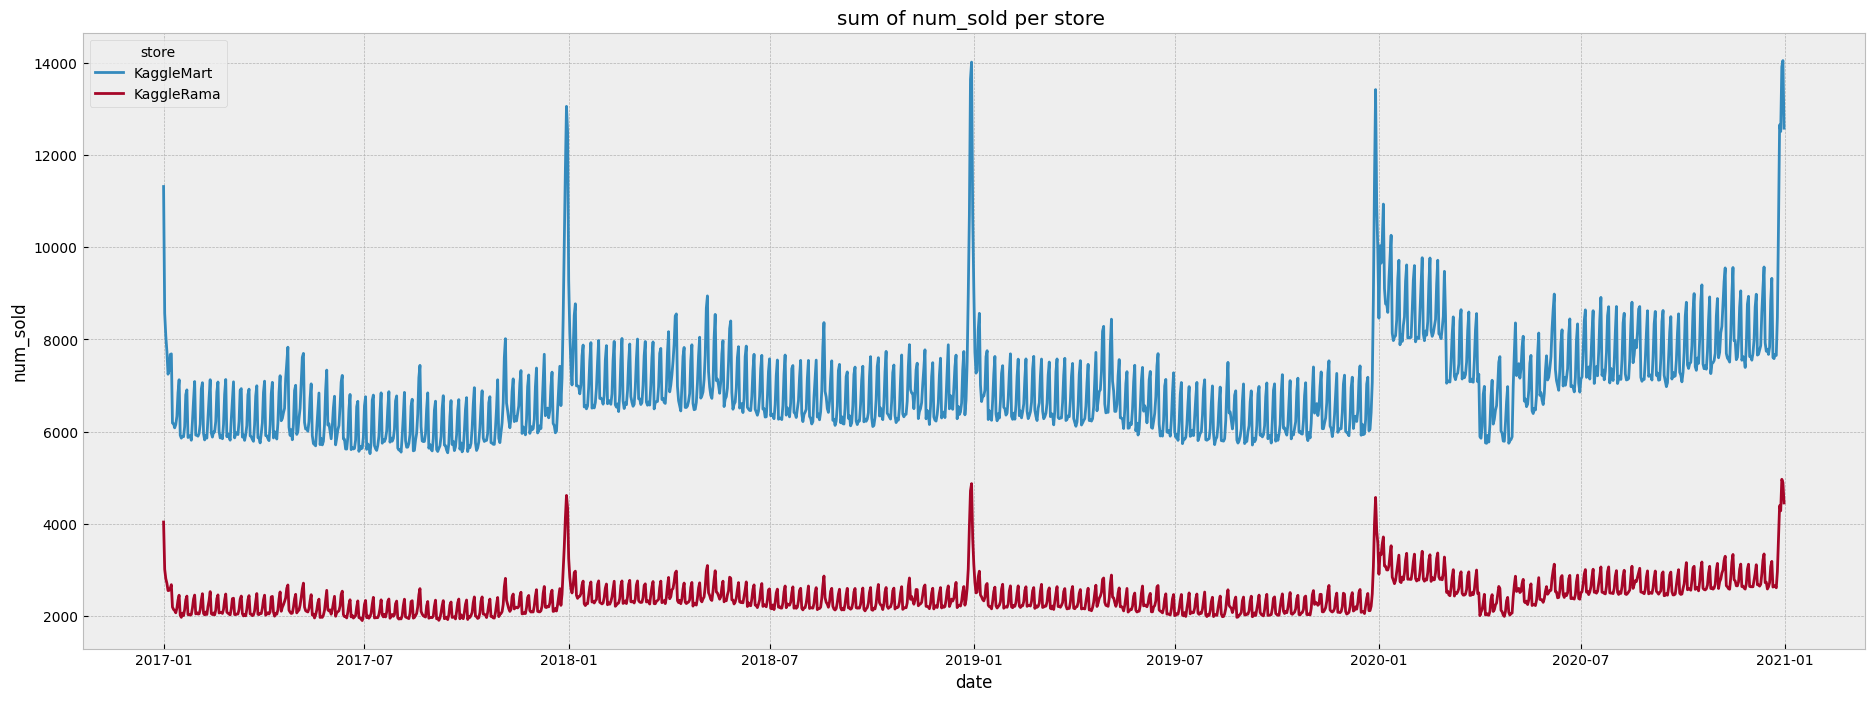

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='store',data=(train_df.groupby(['date', 'store']).num_sold.sum().to_frame()))
ax.set_title("sum of num_sold per store ")

Text(0.5, 1.0, 'sum of num_sold per country')

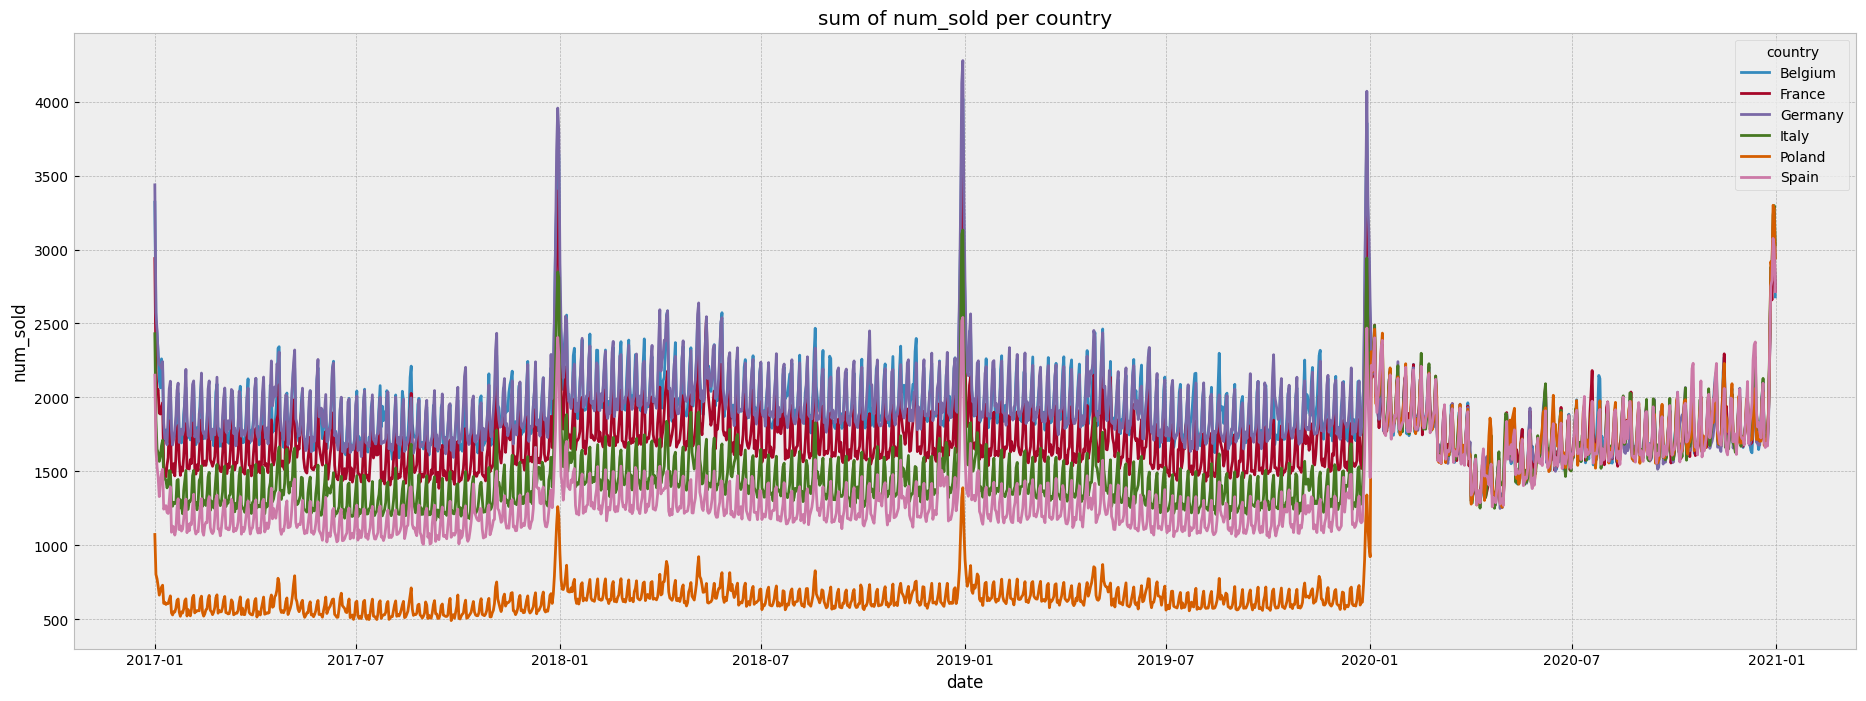

In [56]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='country',data=(train_df.groupby(['date', 'country']).num_sold.sum().to_frame()))
ax.set_title("sum of num_sold per country")

What we notice:
- The pattern of the data changes significantly in 2020 compared to previous years. The drop of sales around March~May is mostly due to COVID-19 restrictions and lockdown.
- A significant increase of the sales average during 2020 compared to 2017~2019. This cab due to population
- In general, data seem to contain weekly and annual seasonalities, and an increase of sales in weekends. We also notice a significant increase during end-of-year holidays.

Text(0.5, 1.0, 'Density plot for num_sold per country')

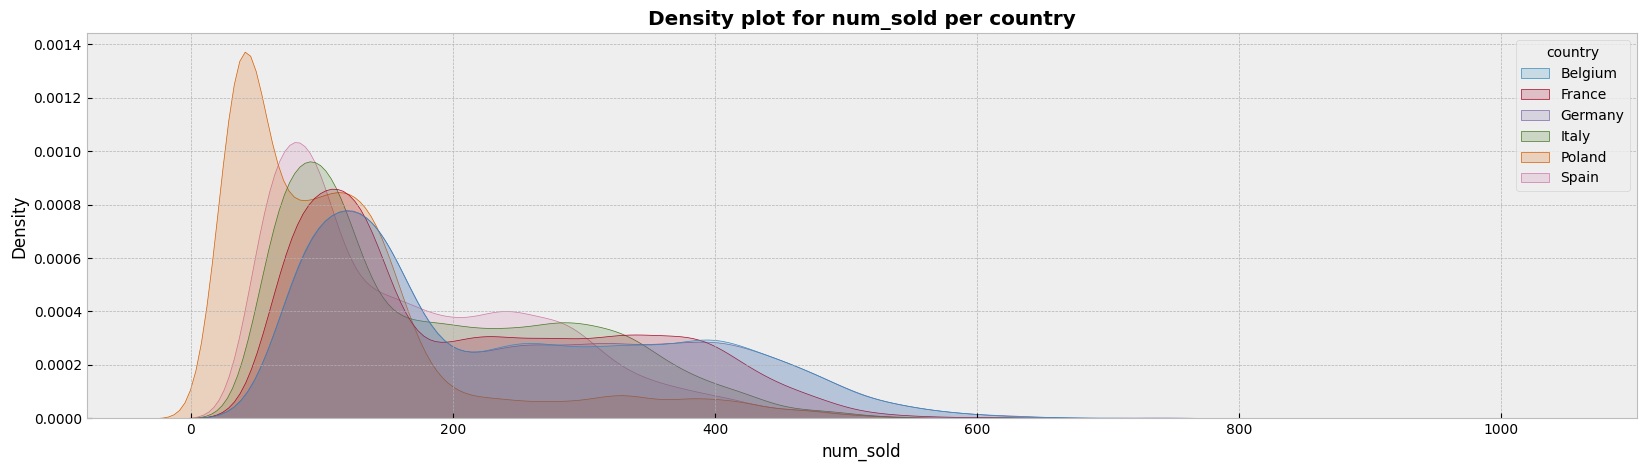

In [57]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=train_df, x='num_sold', hue = 'country', fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per country', fontweight = 'bold')

Text(0.5, 1.0, 'Density plot for num_sold per store')

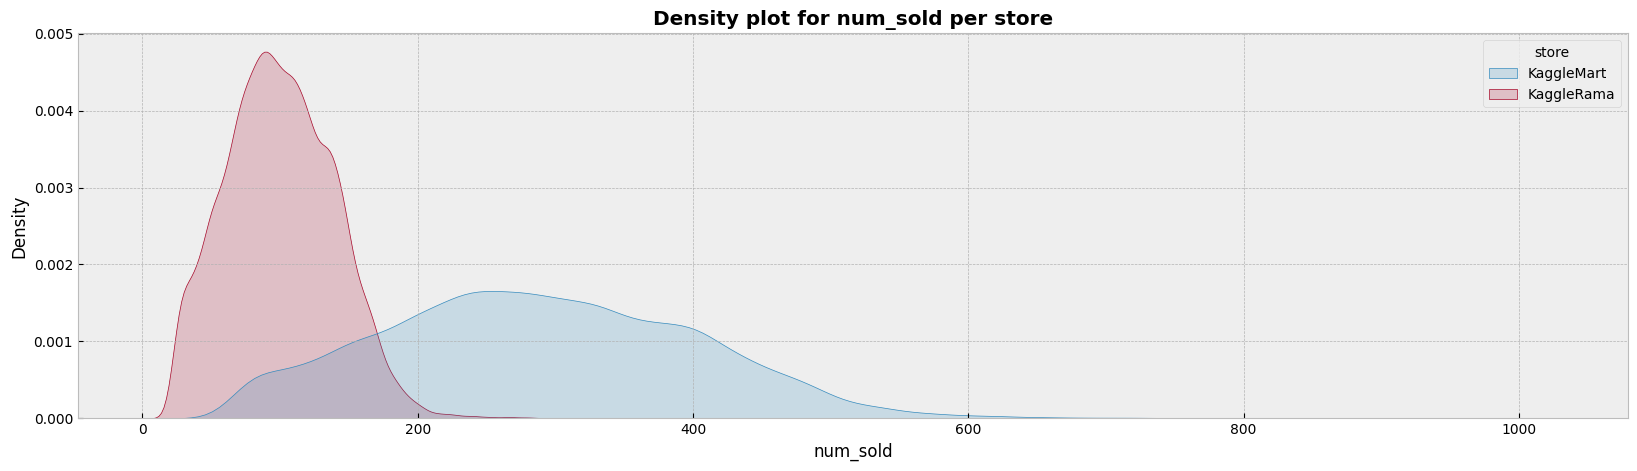

In [58]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=train_df, x='num_sold', hue = 'store', fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per store', fontweight = 'bold')

Text(0.5, 1.0, 'Density plot for num_sold per product')

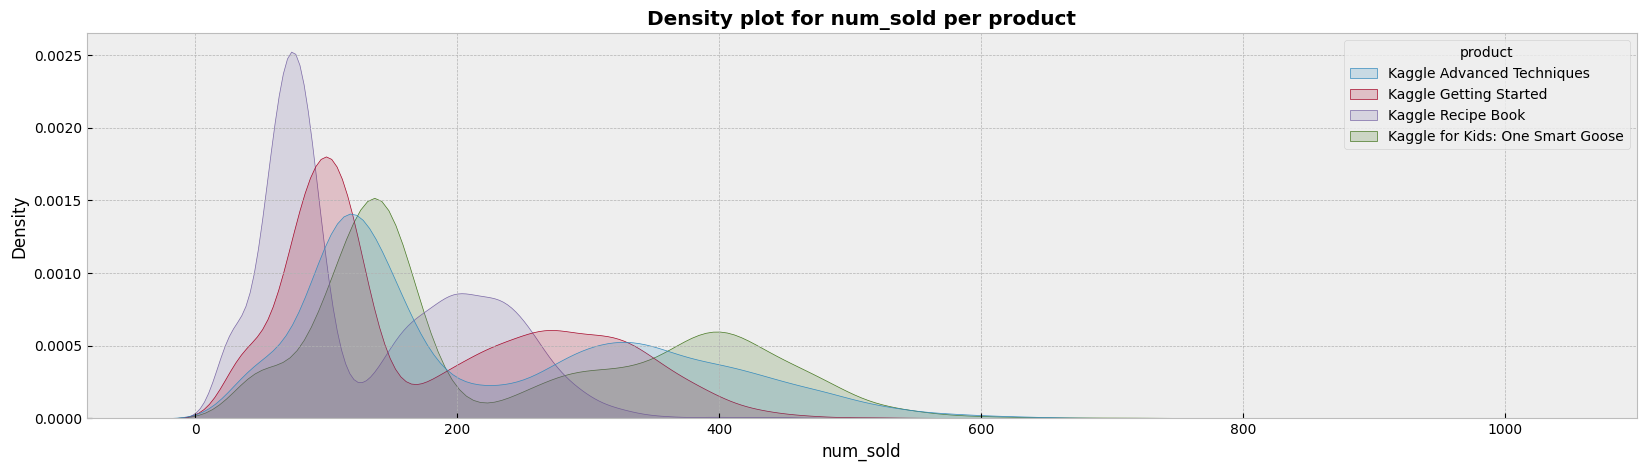

In [59]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=train_df, x='num_sold', hue = 'product', fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per product', fontweight = 'bold')

<Axes: title={'center': 'num_sold'}, xlabel='[product]'>

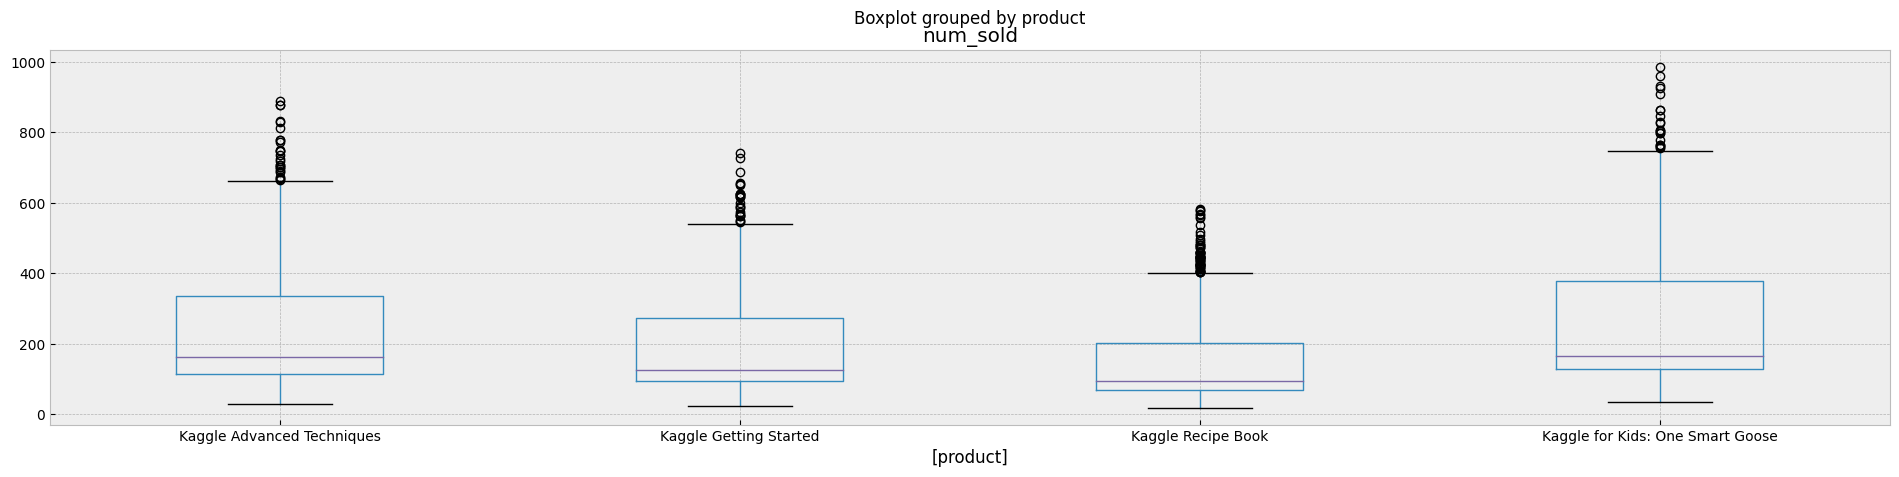

In [60]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5))
train_df.set_index("date")[["product", "num_sold"]].boxplot(by="product", ax=ax)

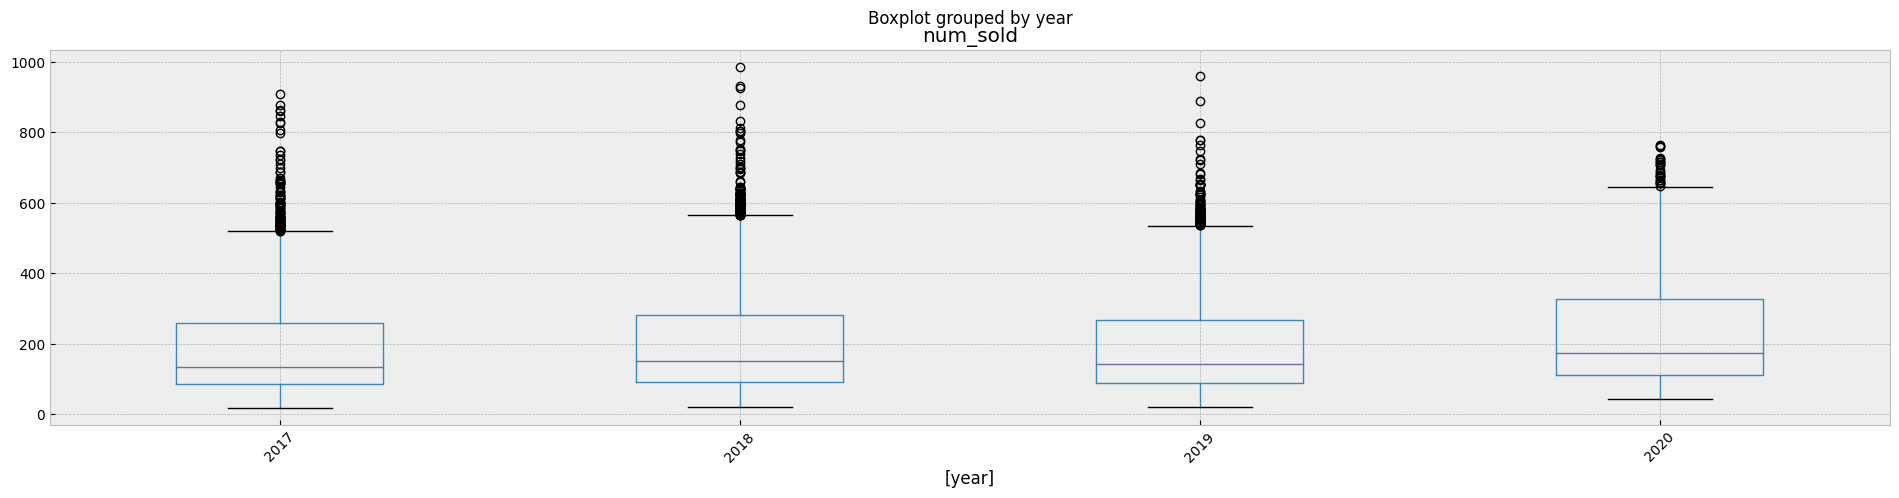

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5))
df_box = train_df.set_index("date")
df_box['year'] = df_box.index.to_period('Y')
df_box['month'] = df_box.index.to_period('M')

df_box[["year", "num_sold"]].boxplot(by="year", ax=ax)
# df_box.loc[:,["month", "num_sold"]].boxplot(by="month", ax=ax)
plt.xticks(rotation=45);

Text(0.5, 1.0, 'Density plot for num_sold per weekday')

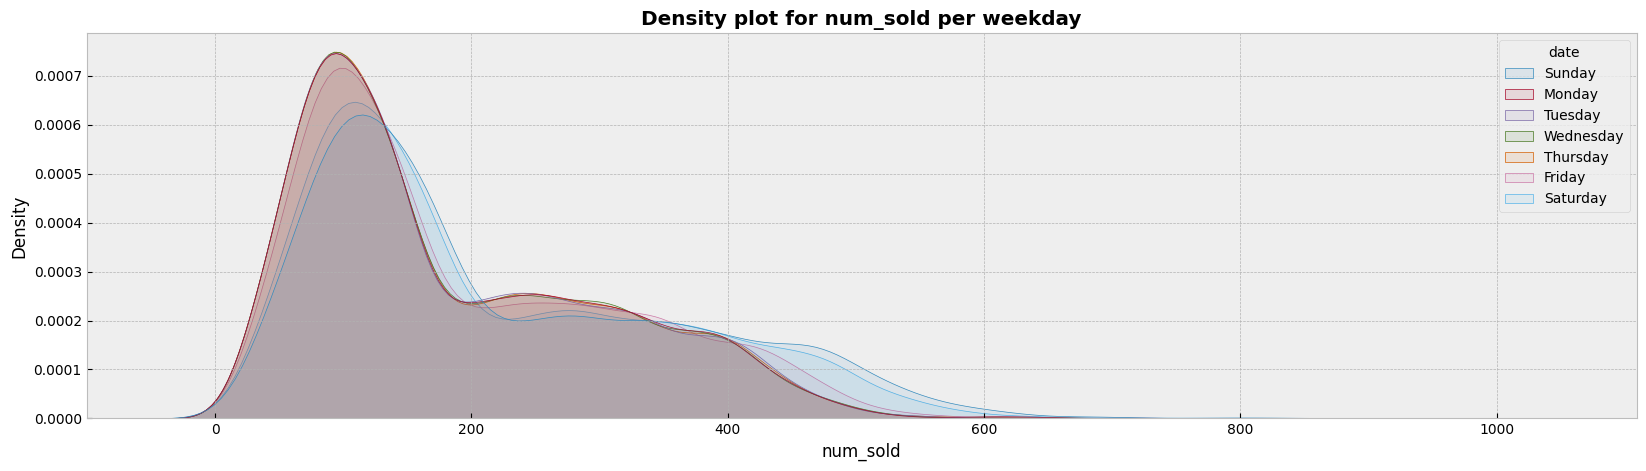

In [62]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=train_df, x='num_sold', hue =train_df.set_index("date").index.day_name(), fill=True, alpha = 0.1, ax = ax)
# sns.boxplot(data=train_df, y='num_sold', x =train_df.set_index("date").index.day_name(), ax = ax)
ax.set_title('Density plot for num_sold per weekday', fontweight = 'bold')

Text(0.5, 1.0, 'Density plot for num_sold per weekday')

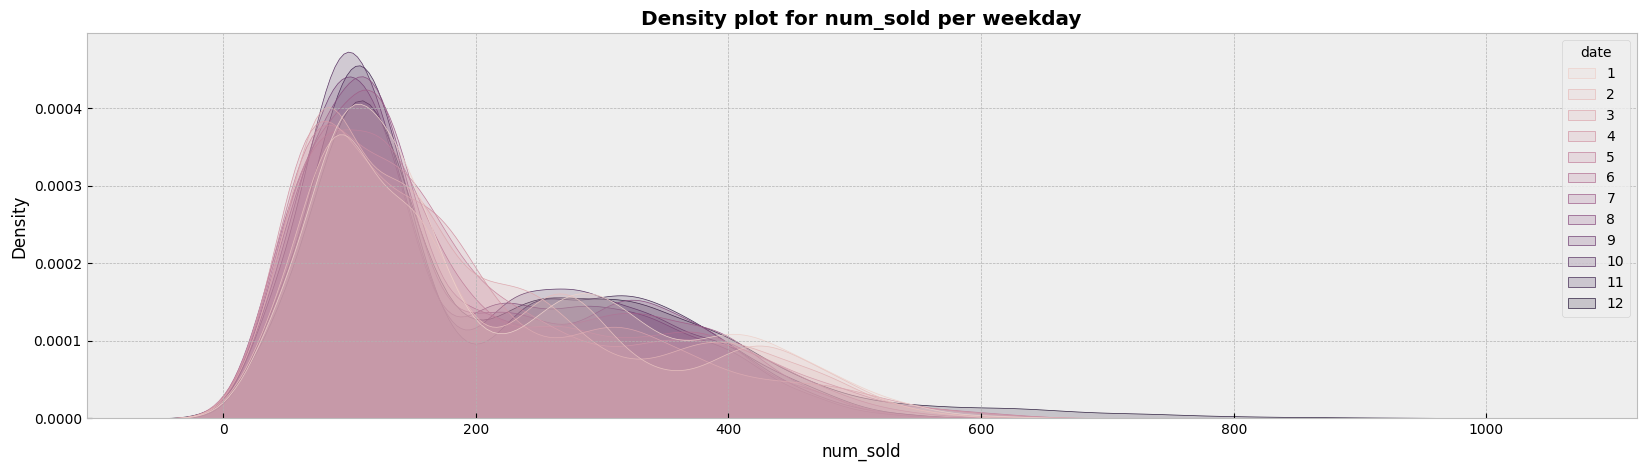

In [63]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=train_df, x='num_sold', hue =train_df.set_index("date").index.month, fill=True, alpha = 0.2, ax = ax)
# sns.boxplot(data=train_df, y='num_sold', x =train_df.set_index("date").index.month, ax = ax)
ax.set_title('Density plot for num_sold per weekday', fontweight = 'bold')

### Check dominant frequencies

In [64]:
# for column in ['day', 'week', 'month']:
df = train_df.groupby(['date', 'product']).num_sold.sum().unstack()
df

product     Kaggle Advanced Techniques  Kaggle Getting Started  \
date                                                             
2017-01-01                        4267                    3492   
2017-01-02                        3242                    2597   
2017-01-03                        3173                    2463   
2017-01-04                        2948                    2354   
2017-01-05                        2773                    2232   
...                                ...                     ...   
2020-12-27                        4749                    3870   
2020-12-28                        4819                    3622   
2020-12-29                        5226                    4248   
2020-12-30                        5281                    4233   
2020-12-31                        4968                    3780   

product     Kaggle Recipe Book  Kaggle for Kids: One Smart Goose  
date                                                              
2017-01-01                2900                              4693  
2017-01-02                2119                              3620  
2017-01-03                2022                              3226  
2017-01-04                1998                              3145  
2017-01-05                1787                              3003  
...                        ...                               ...  
2020-12-27                3199                              5224  
2020-12-28                3205                              5143  
2020-12-29                3575                              5827  
2020-12-30                3725                              5699  
2020-12-31                3301                              4982  

[1461 rows x 4 columns]

In [65]:
freq = "1D"  # 1 day
sampling_interval = 24*60*60  # in seconds
sampling_frequency = 1.0 / sampling_interval  # sampling freq in Hz

Text(0, 0.5, 'PSD [V**2/Hz]')

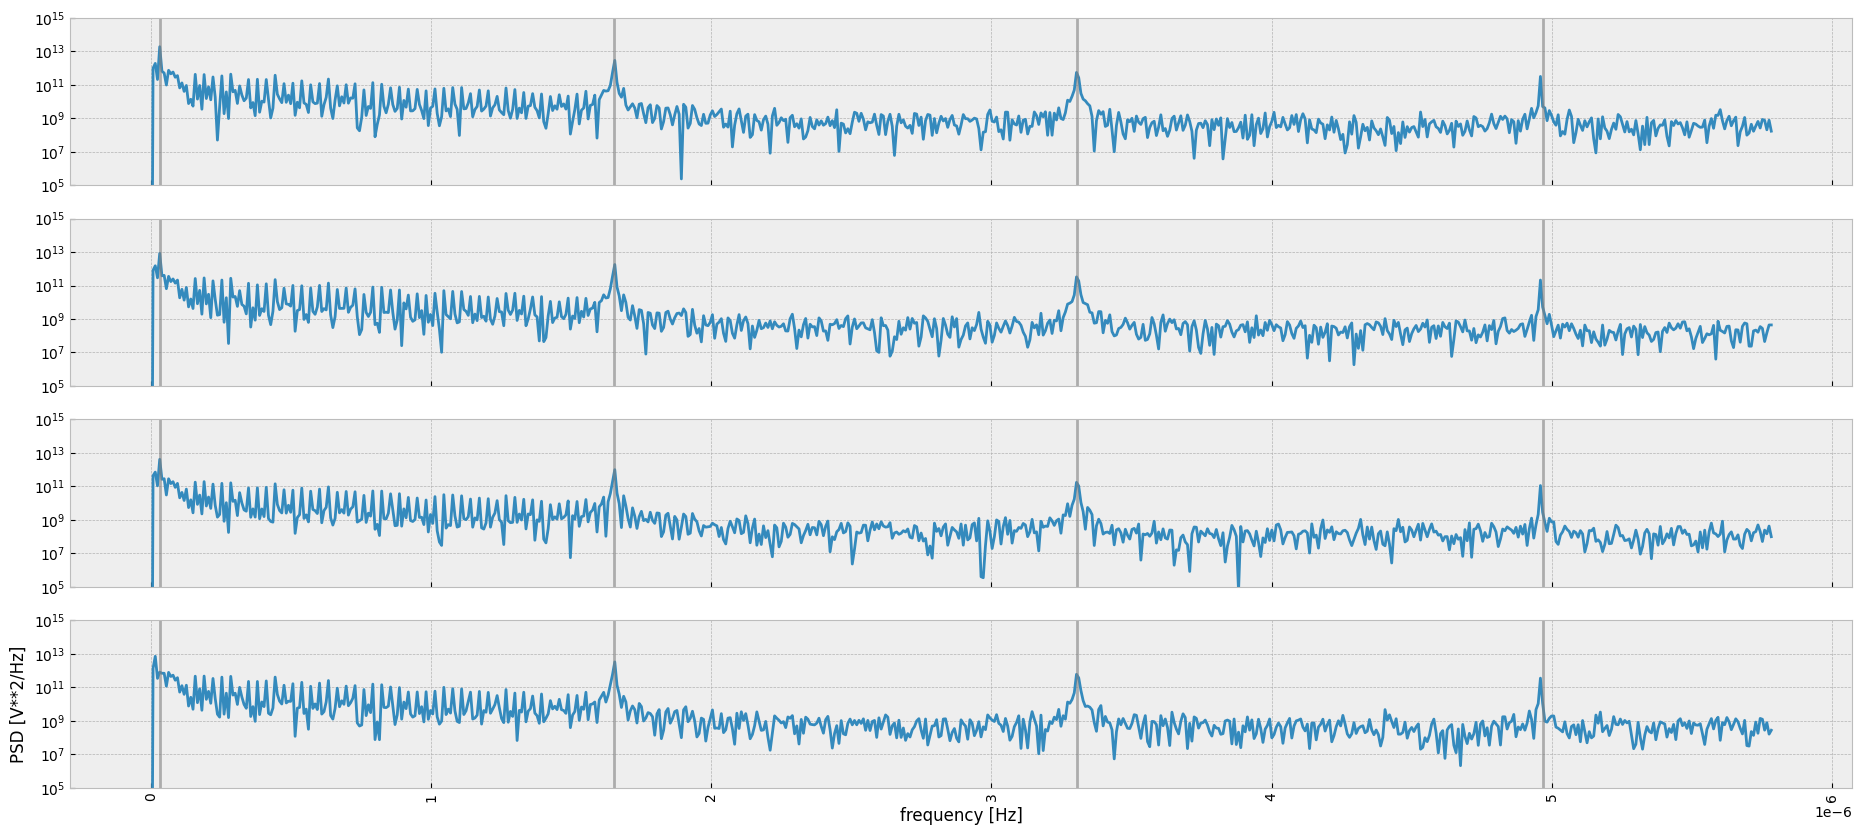

In [66]:
fig, axes = plt.subplots(df.shape[1], 1, figsize=(23,10), sharex=True)

for ax, product in zip(axes, df.columns):

    f, Pxx = signal.periodogram(df.loc[slice("2017","2020"),product], fs=sampling_frequency) 
    ax.semilogy(f, Pxx)
    ax.set_ylim([1e5, 1e15])
    
    for freq in [1.0/(sampling_interval*365), 1.0/(sampling_interval*7), 1.0/(sampling_interval*3.5), 1.0/(sampling_interval*2.33)]:
        ax.vlines(x=freq, color="gray", ymin=1e5, ymax=1e15, alpha=0.6)

plt.xticks(rotation=90)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

### Adding calendar features

To account for weekly and annual seasonalities exhibited by the data, we add the following calendar features: weekend flag, weekday and week of the year. For weekday and week features, we use cyclical encoding.

In [67]:
# add calendar features
train_df_processed = add_cyclical_calendar_features(train_df.set_index("date"), features=["weekday", "week"])
train_df_processed["weekend"] = (train_df_processed.index.dayofweek > 4).astype(int)
train_df_processed

/tmp/ipykernel_1884572/3552040668.py:46: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(df.index, feat)


row_id  country       store                           product  \
date                                                                        
2017-01-01       0  Belgium  KaggleMart        Kaggle Advanced Techniques   
2017-01-01       1  Belgium  KaggleMart            Kaggle Getting Started   
2017-01-01       2  Belgium  KaggleMart                Kaggle Recipe Book   
2017-01-01       3  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
2017-01-01       4  Belgium  KaggleRama        Kaggle Advanced Techniques   
...            ...      ...         ...                               ...   
2020-12-31   70123    Spain  KaggleMart  Kaggle for Kids: One Smart Goose   
2020-12-31   70124    Spain  KaggleRama        Kaggle Advanced Techniques   
2020-12-31   70125    Spain  KaggleRama            Kaggle Getting Started   
2020-12-31   70126    Spain  KaggleRama                Kaggle Recipe Book   
2020-12-31   70127    Spain  KaggleRama  Kaggle for Kids: One Smart Goose   

            num_sold  weekday_sin  weekday_cos      week_sin  week_cos  \
date                                                                     
2017-01-01       663    -0.781831     0.623490  6.432491e-16  1.000000   
2017-01-01       615    -0.781831     0.623490  6.432491e-16  1.000000   
2017-01-01       480    -0.781831     0.623490  6.432491e-16  1.000000   
2017-01-01       710    -0.781831     0.623490  6.432491e-16  1.000000   
2017-01-01       240    -0.781831     0.623490  6.432491e-16  1.000000   
...              ...          ...          ...           ...       ...   
2020-12-31       614     0.433884    -0.900969  1.205367e-01  0.992709   
2020-12-31       215     0.433884    -0.900969  1.205367e-01  0.992709   
2020-12-31       158     0.433884    -0.900969  1.205367e-01  0.992709   
2020-12-31       135     0.433884    -0.900969  1.205367e-01  0.992709   
2020-12-31       202     0.433884    -0.900969  1.205367e-01  0.992709   

            weekend  
date                 
2017-01-01        1  
2017-01-01        1  
2017-01-01        1  
2017-01-01        1  
2017-01-01        1  
...             ...  
2020-12-31        0  
2020-12-31        0  
2020-12-31        0  
2020-12-31        0  
2020-12-31        0  

[70128 rows x 10 columns]

We also add boolean flags for national holidays with respect to the country and for end-of-year holidays (from December 24th to 31st)

In [68]:
# add holidays flag
holidays_dates_per_country = {}
for country in train_df_processed["country"].unique():
    holidays_dates_per_country[country]=[tuple[0] for tuple in list(getattr(holidays, country)(years=set(train_df_processed.index.year)).items())]
    train_df_processed.loc[train_df_processed["country"]==country, "holidays"]=train_df_processed.loc[train_df_processed["country"]==country].index.isin(holidays_dates_per_country[country])

train_df_processed["holidays"] = train_df_processed["holidays"].astype(int)

Text(0.5, 1.0, 'sum of num_sold in France')

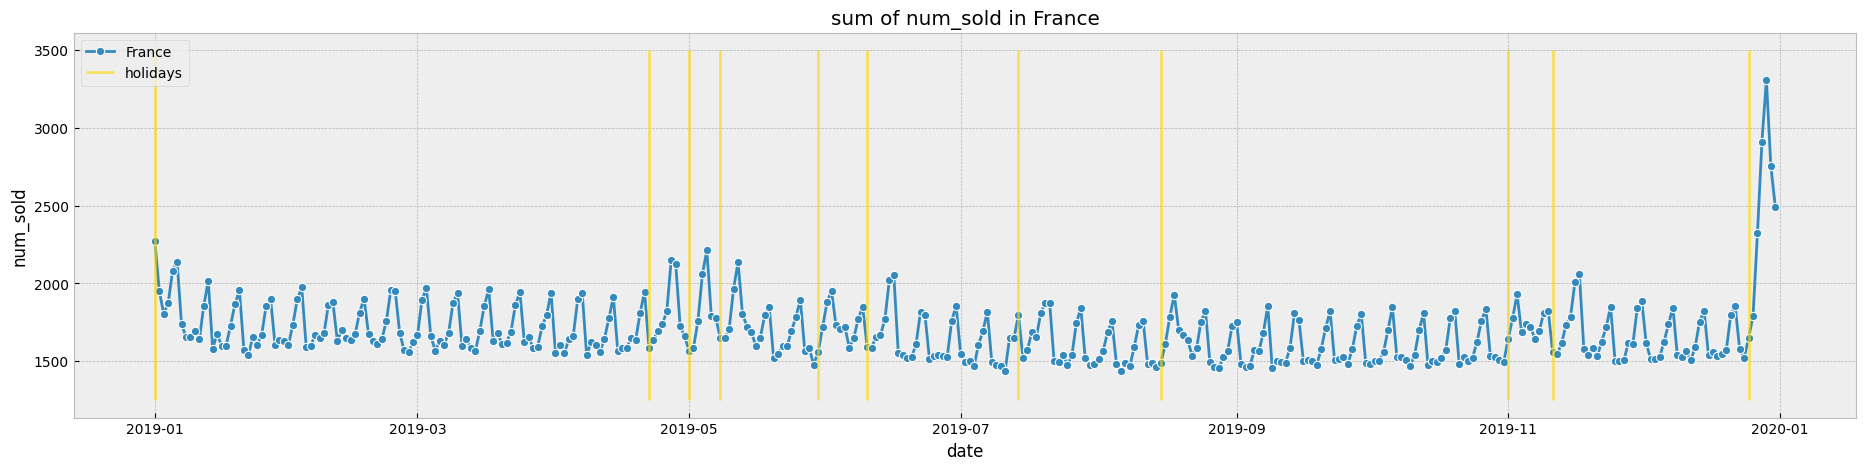

In [69]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5), sharex=True)

df_plot = train_df_processed.groupby(['date', 'country', 'holidays', 'weekend']).num_sold.sum().to_frame()
df_plot = pd.DataFrame(df_plot.to_records()).set_index("date")

country='France'
zoom=slice("2019", "2019")

sns.lineplot(x='date',y='num_sold',hue='country', data=df_plot.loc[df_plot["country"]==country].loc[zoom], ax=ax, marker="o")
ax.vlines(x=df_plot.loc[(df_plot["holidays"]) & (df_plot["country"]==country)].loc[zoom].index, ymin=1250, ymax=3500, color='gold', alpha=0.6, label="holidays")
# ax.vlines(x=df_plot.loc[(df_plot["weekend"]) & (df_plot["country"]==country)].loc['05-2018'].index, ymin=1250, ymax=3500, color='silver', alpha=0.6, label="weekend")

plt.legend()
ax.set_title("sum of num_sold in France")

In [70]:
# add end-of-year holidays flag
train_df_processed["newyear"]=0
for day in range(25,32):
    train_df_processed.loc[(train_df_processed.index.month == 12) & (train_df_processed.index.day == day),"newyear"]=1

In [71]:
# drop year 2020
# train_df_processed = train_df_processed.drop(index=train_df_processed.loc[train_df_processed.index.year == 2020].index)
# train_df_processed

### Scale sales level across years 

In [72]:
# Add a year column
train_df_processed["year"]=train_df_processed.index.year

In [73]:
# Get average sales for each country in each year
mean_country_year = train_df_processed[['country', 'year', "num_sold"]].groupby(['country', 'year'], as_index=False).mean()

In [74]:
# Scale up the average sales of years 2017~2019 to match 2020
for country in train_df_processed.country.unique():
    mean_2020 = mean_country_year.loc[(mean_country_year['year'] == 2020) & (mean_country_year['country'] == country), 'num_sold'].values[0]

    for year in train_df_processed.year.unique():
        if year==2020:
            break
        mean_year = mean_country_year.loc[(mean_country_year['year'] == year) & (mean_country_year['country'] == country), 'num_sold'].values[0]
        factor = mean_2020/mean_year
        train_df_processed.loc[(train_df_processed["country"]==country) & (train_df_processed["year"]==year),"num_sold"]= train_df_processed.loc[(train_df_processed["country"]==country) & (train_df_processed["year"]==year),"num_sold"]*factor

Text(0.5, 1.0, 'sum of num_sold per country')

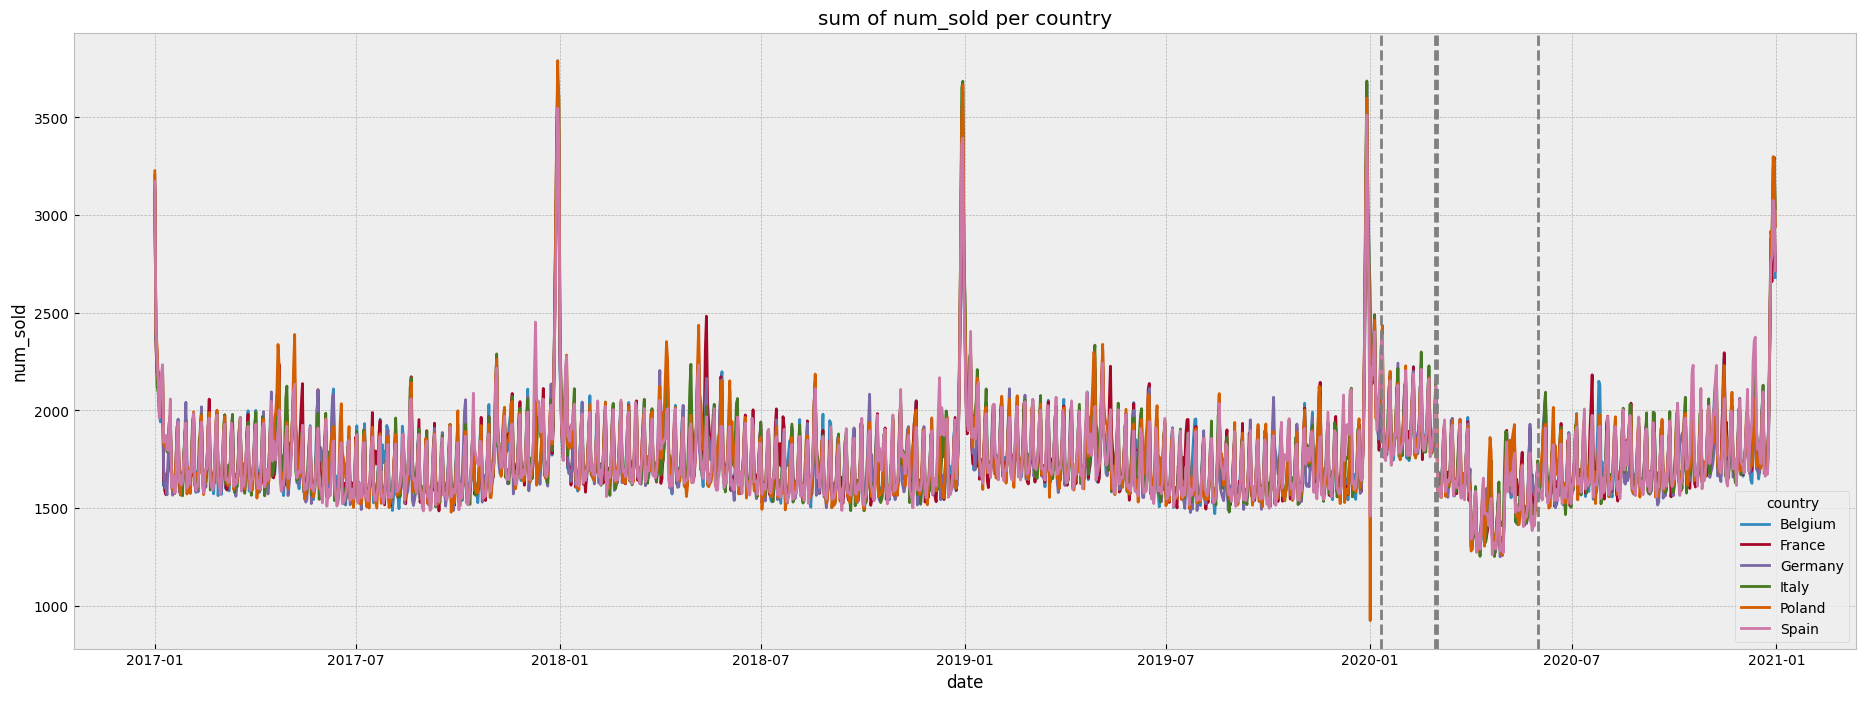

In [75]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='country',data=train_df_processed.groupby(['date', 'country']).num_sold.sum().to_frame())

# lockdown effect
plt.axvline(x=pd.Timestamp("2020-03-01"), color="gray", linestyle='--')
plt.axvline(x=pd.Timestamp("2020-05-31"), color="gray", linestyle='--')

plt.axvline(x=pd.Timestamp("2020-01-11"), color="gray", linestyle='--')
plt.axvline(x=pd.Timestamp("2020-02-28"), color="gray", linestyle='--')

# ax.vlines(x=train_df_processed.loc[train_df_processed["holidays"]==1].index, ymin=1250, ymax=3500, color='gold', alpha=0.6, label="holidays")
ax.set_title("sum of num_sold per country")

March~May of 2020 do not reflect the general patterns that we want our model to learn, as they would not be generalizeable to following years. Including the these months data would negatively impact our model generalization performance. The most straightforward solution for this is to simply remove them

In [76]:
# handle 01-01-2020 outlier
train_df_processed.loc[pd.Timestamp('2020-01-01'), "num_sold"]=np.nan

df_shifted = pd.concat(
        [train_df_processed[["num_sold"]].shift(periods=365*48*x) for x in range(3)], axis=1
    )
train_df_processed[["num_sold"]] = train_df_processed[["num_sold"]].fillna(df_shifted.groupby(by=df_shifted.columns, axis=1).mean())

In [77]:
# handle March~May outliers
train_df_processed.loc[(train_df_processed.year==2020)&(train_df_processed.index.month.isin([3,4,5])), "num_sold"]=np.nan

df_shifted = pd.concat(
        [train_df_processed[["num_sold"]].shift(periods=52*7*48*x) for x in range(3)], axis=1
    )
train_df_processed[["num_sold"]] = train_df_processed[["num_sold"]].fillna(df_shifted.groupby(by=df_shifted.columns, axis=1).mean())

Text(0.5, 1.0, 'sum of num_sold per country')

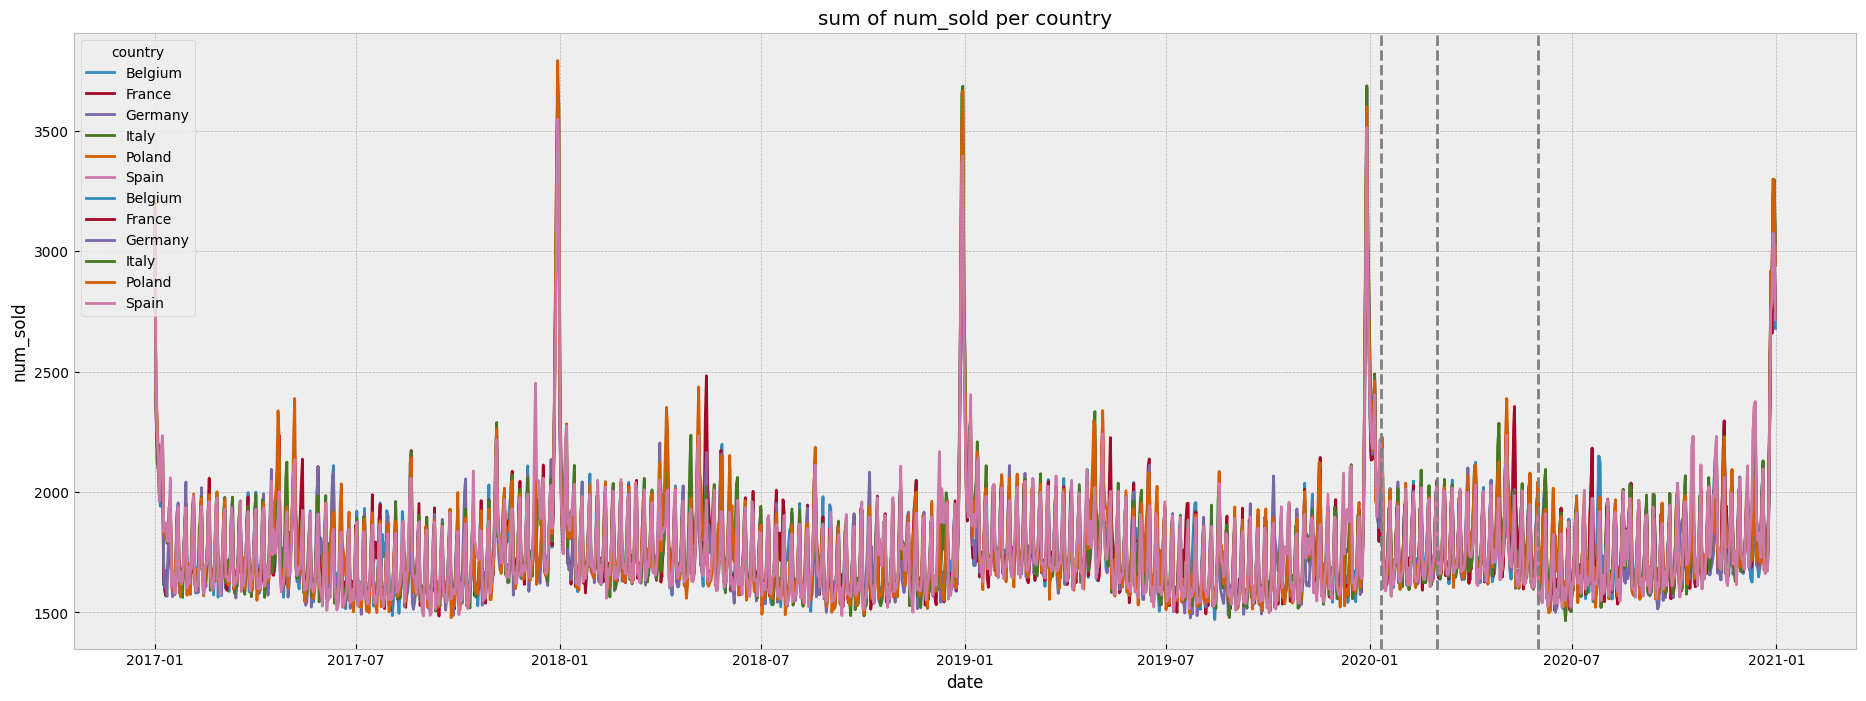

In [115]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
# sns.lineplot(x='date',y='num_sold',hue='country',data=(train_df_processed.loc[train_df_processed.year==2020].groupby(['date', 'country']).num_sold.sum().to_frame()))
sns.lineplot(x='date',y='num_sold',hue='country',data=(train_df_processed.groupby(['date', 'country']).num_sold.sum().to_frame()))

# lockdown effect
plt.axvline(x=pd.Timestamp("2020-03-01"), color="gray", linestyle='--')
plt.axvline(x=pd.Timestamp("2020-05-31"), color="gray", linestyle='--')

plt.axvline(x=pd.Timestamp("2020-01-11"), color="gray", linestyle='--')

ax.set_title("sum of num_sold per country")

In [79]:
# Scale up the average sales between 11-01-2020 and 29-02-2020 to minimize COVID19 effect
mean_country_slice = train_df_processed.loc[slice("2020-01-11", "2020-02-29"), ['country', "num_sold"]].groupby(['country'], as_index=False).mean()

for country in train_df_processed.country.unique():
    mean_2020 = mean_country_year.loc[(mean_country_year['year'] == 2020) & (mean_country_year['country'] == country), 'num_sold'].values[0]
    mean = mean_country_slice.loc[mean_country_slice["country"]==country, "num_sold"].values[0]
    factor = mean_2020/mean
    train_df_processed.loc[((train_df_processed["country"]==country) & (train_df_processed.index>="2020-01-11") &(train_df_processed.index<="2020-02-29")),"num_sold"]= train_df_processed.loc[((train_df_processed["country"]==country) & (train_df_processed.index>="2020-01-11") &(train_df_processed.index<="2020-02-29")),"num_sold"]*factor

Text(0.5, 1.0, 'sum of num_sold per country')

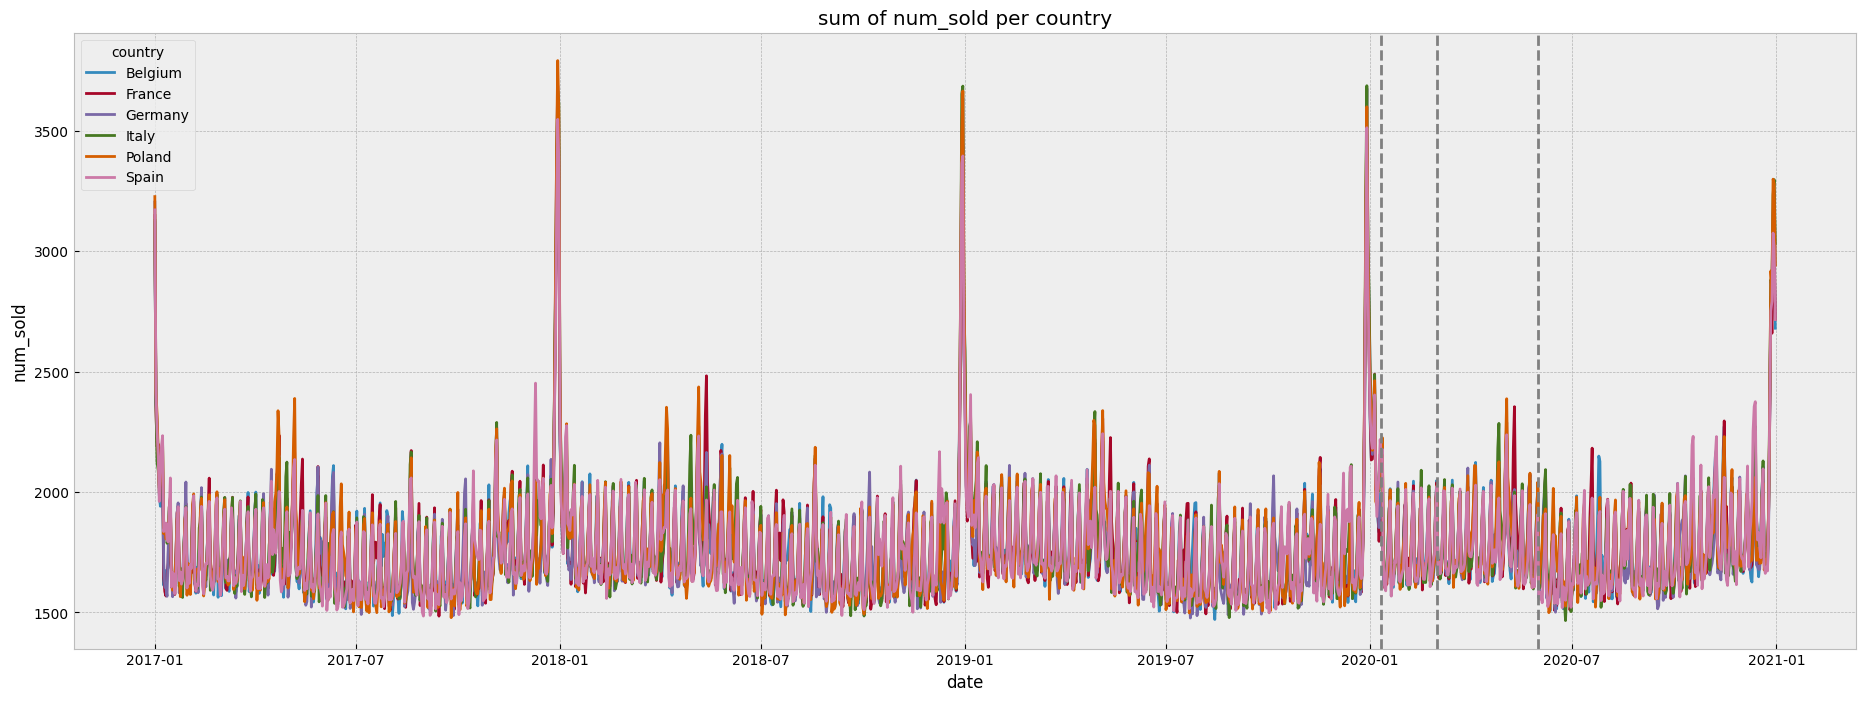

In [80]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
# sns.lineplot(x='date',y='num_sold',hue='country',data=(train_df_processed.loc[train_df_processed.year==2020].groupby(['date', 'country']).num_sold.sum().to_frame()))
sns.lineplot(x='date',y='num_sold',hue='country',data=(train_df_processed.groupby(['date', 'country']).num_sold.sum().to_frame()))

# lockdown effect
plt.axvline(x=pd.Timestamp("2020-03-01"), color="gray", linestyle='--')
plt.axvline(x=pd.Timestamp("2020-05-31"), color="gray", linestyle='--')

plt.axvline(x=pd.Timestamp("2020-01-11"), color="gray", linestyle='--')

ax.set_title("sum of num_sold per country")

Text(0.5, 1.0, 'sum of num_sold per store')

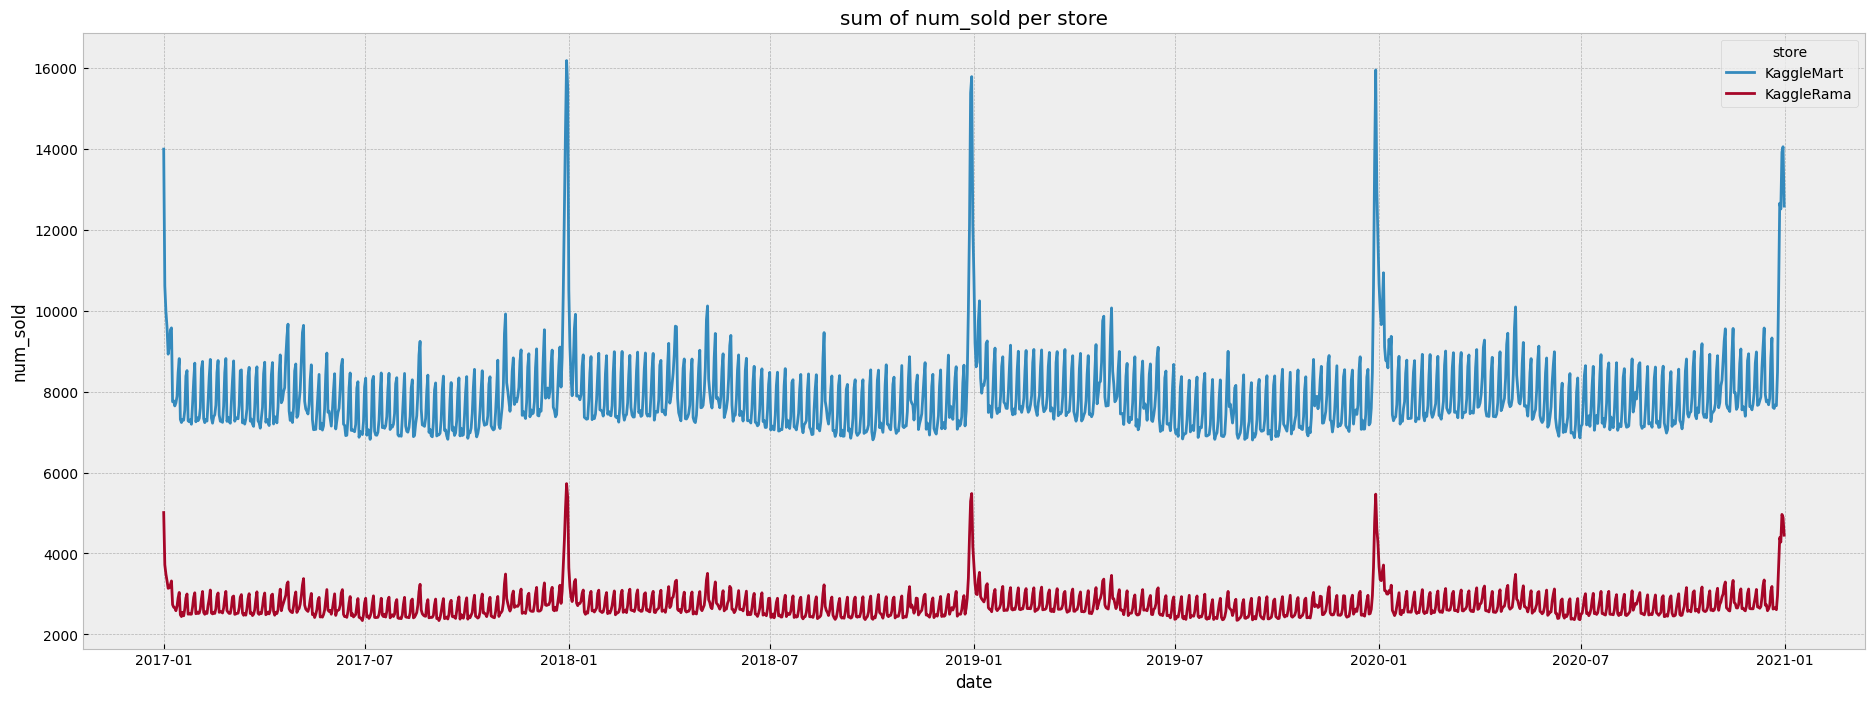

In [81]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='store',data=(train_df_processed.groupby(['date', 'store']).num_sold.sum().to_frame()))
ax.set_title("sum of num_sold per store")

Text(0.5, 1.0, 'sum of num_sold per product')

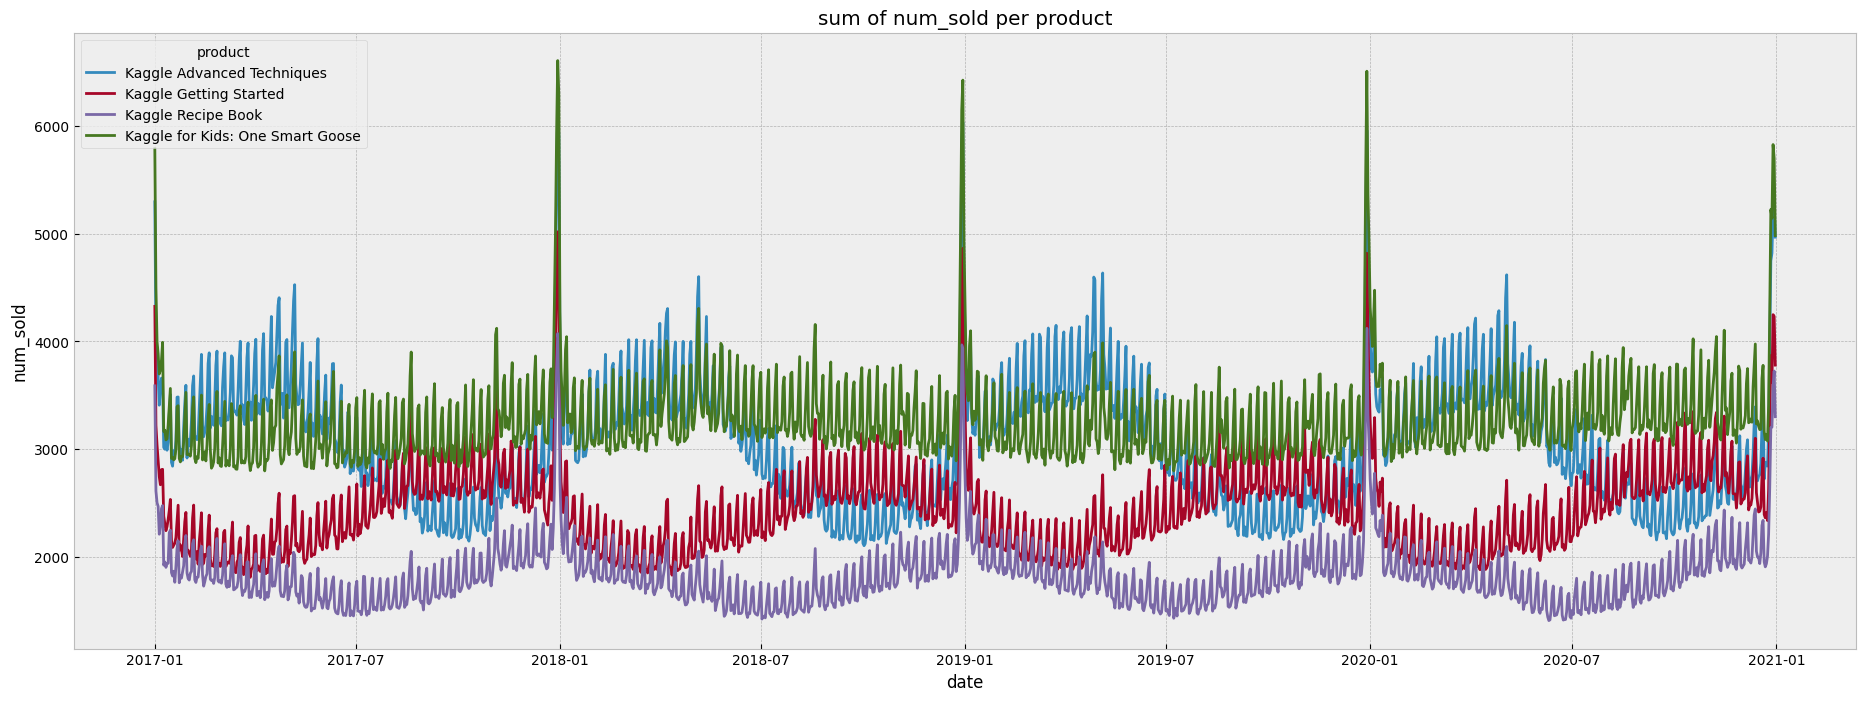

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='date',y='num_sold',hue='product',data=(train_df_processed.groupby(['date', 'product']).num_sold.sum().to_frame()))
ax.set_title("sum of num_sold per product")

That looks better for now 

## Pytorch Forecasting
### Dataset objects

To use the TFT model implementation in the `Pytorch Forecasting` library, we use the TimeSeriesDataSet class to encapsulate the data, its variables (names of the target variable, static covariates, time varying known and unknown variables, lagged values), variable encoders, scalers, the max and min lengths of the encoder input and decoder output, etc. 

Static convariates in TFT consist in static metadata about measured entities (i.e. books) that do no depend on time. In our dataset, static covariates consist in `country`, `store` and `product` features.

Static covariates are used to define `groups` to separate individual times series. The number of time series present in our dataset is the number of all possible combinations of static covariates values. In our use case, we will have 48 individual time series : $$number of countries \times number of stores \times number of products$$

`TimeSeriesDataSet` also expects the provided data to contain an integer column denoting the time index. This time index should start by 1 and increment by +1 for each individual time series if there are no missing time steps. 
We replace our date column with time_idx:

In [83]:
train = train_df_processed.reset_index()
train = (train.merge((train[['date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['date'])).drop(["date", "row_id"], axis=1)
train

country       store                           product    num_sold  \
0      Belgium  KaggleMart        Kaggle Advanced Techniques  623.047605   
1      Belgium  KaggleMart            Kaggle Getting Started  577.940086   
2      Belgium  KaggleMart                Kaggle Recipe Book  451.075189   
3      Belgium  KaggleMart  Kaggle for Kids: One Smart Goose  667.215384   
4      Belgium  KaggleRama        Kaggle Advanced Techniques  225.537595   
...        ...         ...                               ...         ...   
70123    Spain  KaggleMart  Kaggle for Kids: One Smart Goose  614.000000   
70124    Spain  KaggleRama        Kaggle Advanced Techniques  215.000000   
70125    Spain  KaggleRama            Kaggle Getting Started  158.000000   
70126    Spain  KaggleRama                Kaggle Recipe Book  135.000000   
70127    Spain  KaggleRama  Kaggle for Kids: One Smart Goose  202.000000   

       weekday_sin  weekday_cos      week_sin  week_cos  weekend  holidays  \
0        -0.781831     0.623490  6.432491e-16  1.000000        1         1   
1        -0.781831     0.623490  6.432491e-16  1.000000        1         1   
2        -0.781831     0.623490  6.432491e-16  1.000000        1         1   
3        -0.781831     0.623490  6.432491e-16  1.000000        1         1   
4        -0.781831     0.623490  6.432491e-16  1.000000        1         1   
...            ...          ...           ...       ...      ...       ...   
70123     0.433884    -0.900969  1.205367e-01  0.992709        0         0   
70124     0.433884    -0.900969  1.205367e-01  0.992709        0         0   
70125     0.433884    -0.900969  1.205367e-01  0.992709        0         0   
70126     0.433884    -0.900969  1.205367e-01  0.992709        0         0   
70127     0.433884    -0.900969  1.205367e-01  0.992709        0         0   

       newyear  year  time_idx  
0            0  2017         0  
1            0  2017         0  
2            0  2017         0  
3            0  2017         0  
4            0  2017         0  
...        ...   ...       ...  
70123        1  2020      1460  
70124        1  2020      1460  
70125        1  2020      1460  
70126        1  2020      1460  
70127        1  2020      1460  

[70128 rows x 13 columns]

In [84]:
# drop rows with NaN sales
# train = train.dropna()

We use `row_id` to remove the last `max_prediction_length` timesteps from each individual time series, i.e. to make sure that the validation set is held out from the training

In [85]:
max_prediction_length = 365 # a whole year
max_encoder_length = 365

# For training/evaluation splits
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020

Given that our time series data are different in magnitude between different groups (country, store and product), we use a `GroupNormalizer` to normalize each time-series individually.

To account for the autocorrelation in the sales data, we explicitly add lagged features for *t-7* (same time previous week) and *t-365* (previous year)

In [86]:
# Create training set
training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"], # static covariates
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend', 'holidays', 'newyear'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['num_sold'],
    target_normalizer=GroupNormalizer(
        groups=["country", "store", "product"], transformation="softplus"
    ),  # use softplus transformation and normalize by group
    lags={'num_sold': [7,365]}, # add lagged values of target variable
    # allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

We then create a validation TimeSeriesDataSet that has the same parameters as the training dataset object 

In [87]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
                                            train, # data from which new dataset will be generated
                                            predict=True, # predict the decoder length on the last entries in the time index
                                            stop_randomization=True)

### Training/Validation

Pytorch Forecasting implementation is based on *Pytorch Lightning*. Hence, to train the model, we need to define a `Trainer` object and `dataloaders`

In [88]:
# create training and validation dataloaders for model
batch_size = 128 
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [89]:
# define callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(save_dir=SAVE_DIR)  # logging results to a tensorboard

# create trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # run validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
# Create network from TimeSeriesDataSet
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # number of quantiles
    loss=QuantileLoss(),
    log_interval=10,  # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 30.6k


/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [91]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-02 10:57:35.946719: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 10:57:35.968894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 10:57:3

Epoch 24:  10%|█         | 3/30 [00:02<00:20,  1.33it/s, v_num=1, train_loss_step=4.990, val_loss=7.860, train_loss_epoch=4.970] 

/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [92]:
# load the best model w.r.t. the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [93]:
best_model_path

'./models/lightning_logs/version_1/checkpoints/epoch=23-step=720.ckpt'

In [94]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation MAE: 13.587306022644043


In [114]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)
val_prediction_results.output.prediction.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


torch.Size([48, 365, 7])

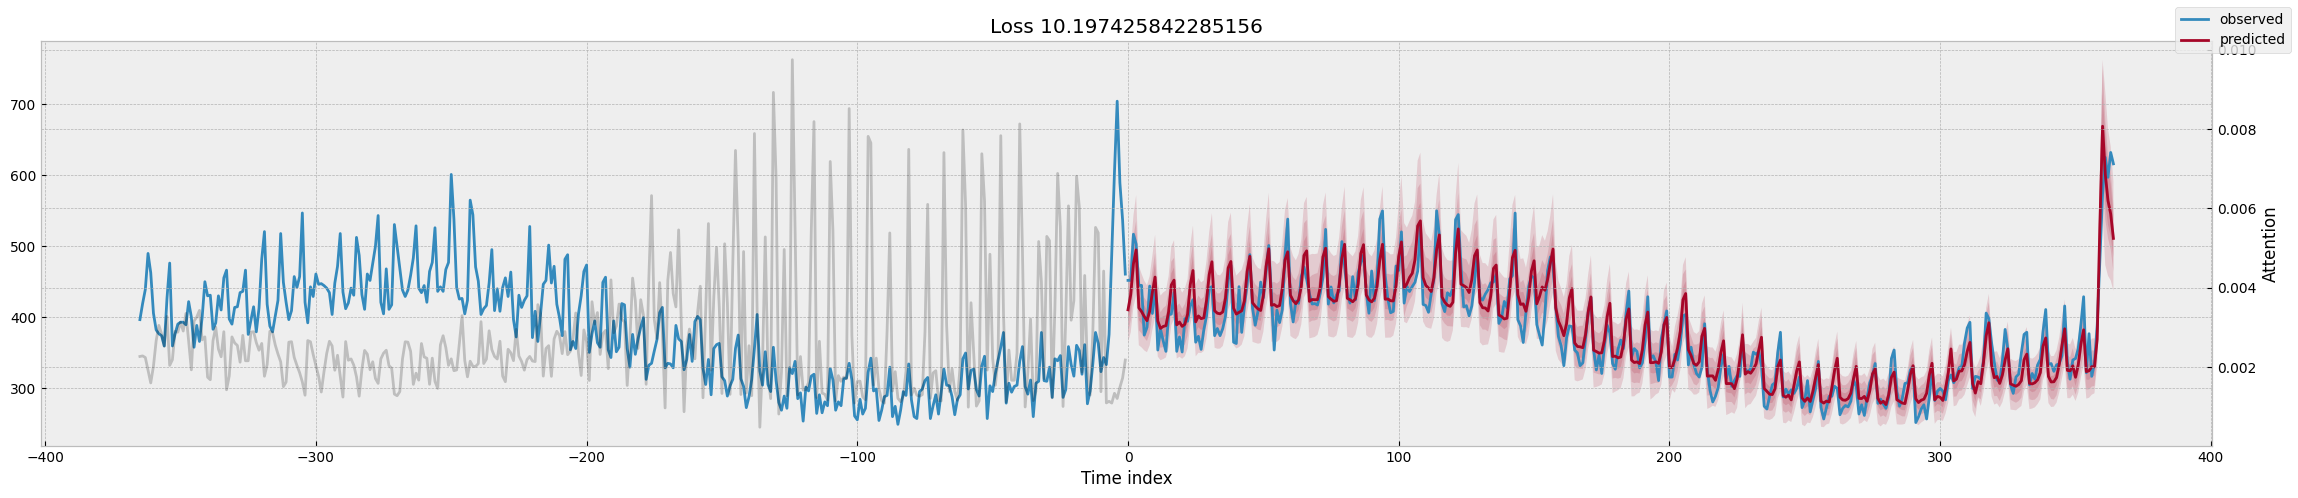

In [52]:
# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

## Hypeparameter Tuning

In the above code, we used pre-fixed hyper-parameters to train our model. Pytorch Forecasting proposes a wrapper function to tune them on the validation set using Optuna 

In [53]:
# # Hyperparameters Tuning with Optuna
# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # pickle study results
# with open("study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# study.best_trial.params

## Interpretability

*Interpretability* is a major property of the *Temporal Fusion Transformer*. *Pytorch Forecasting* enables to get and plot interpretation results from the trained TFT model.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/sh-sungho.park/anaconda3/envs/tft_env/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6


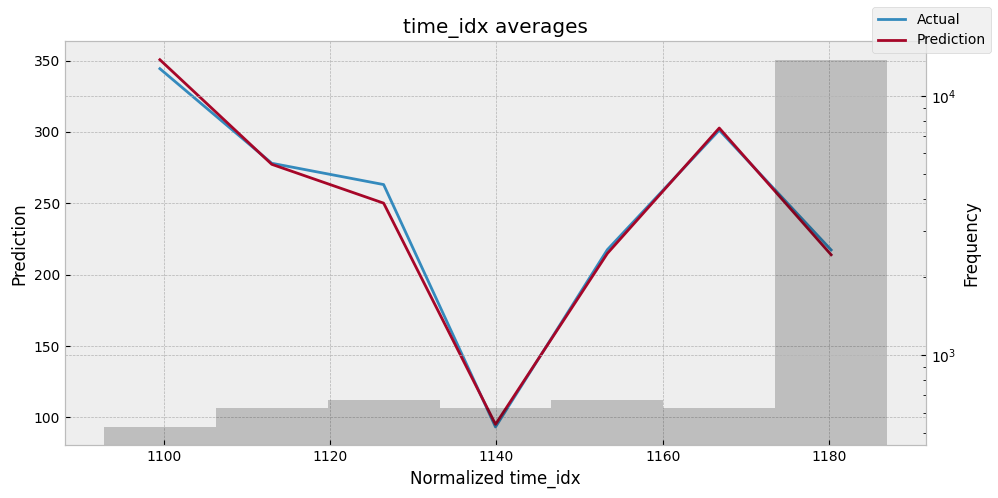

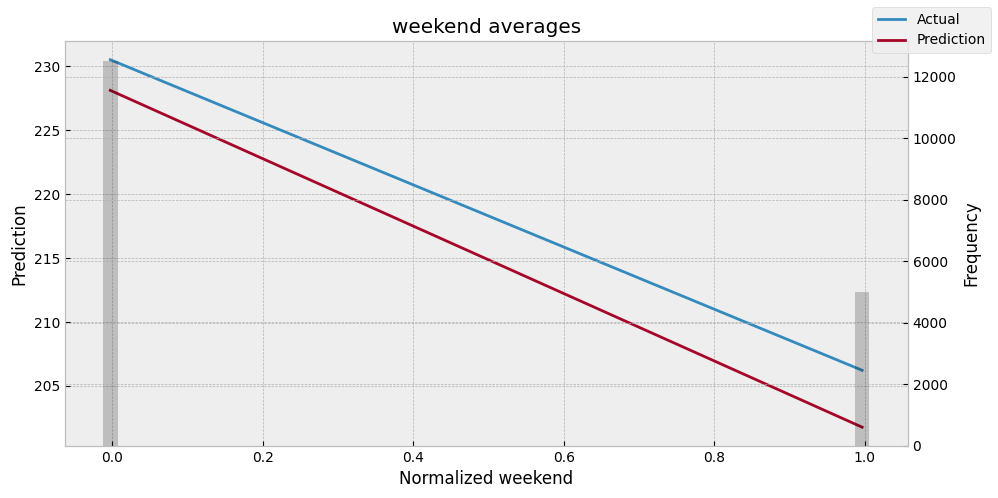

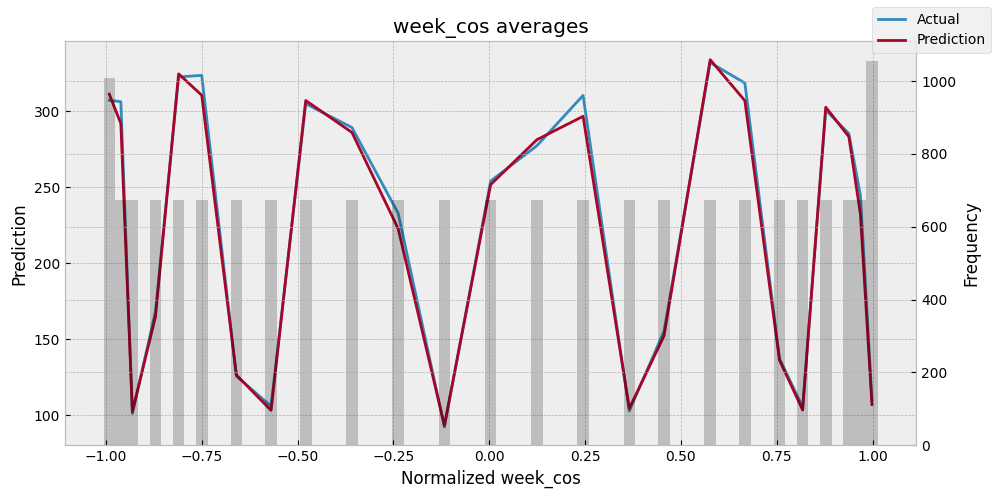

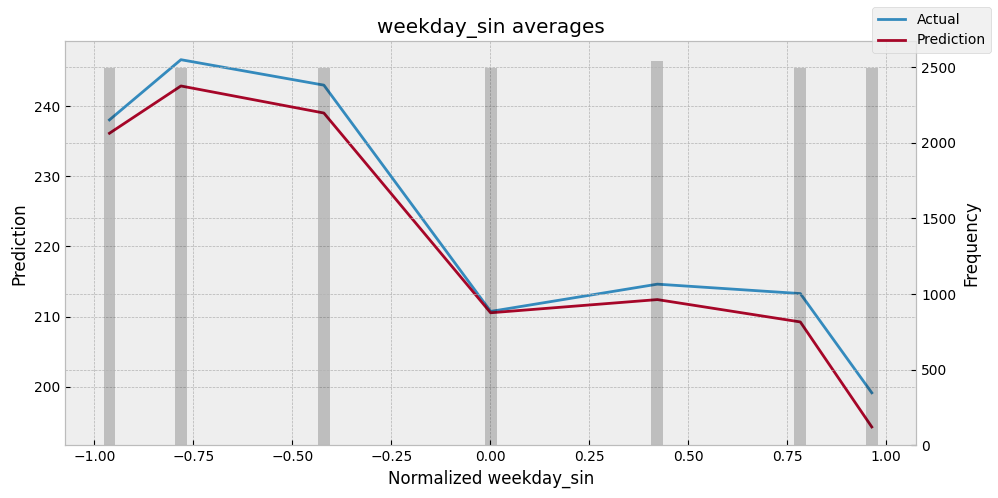

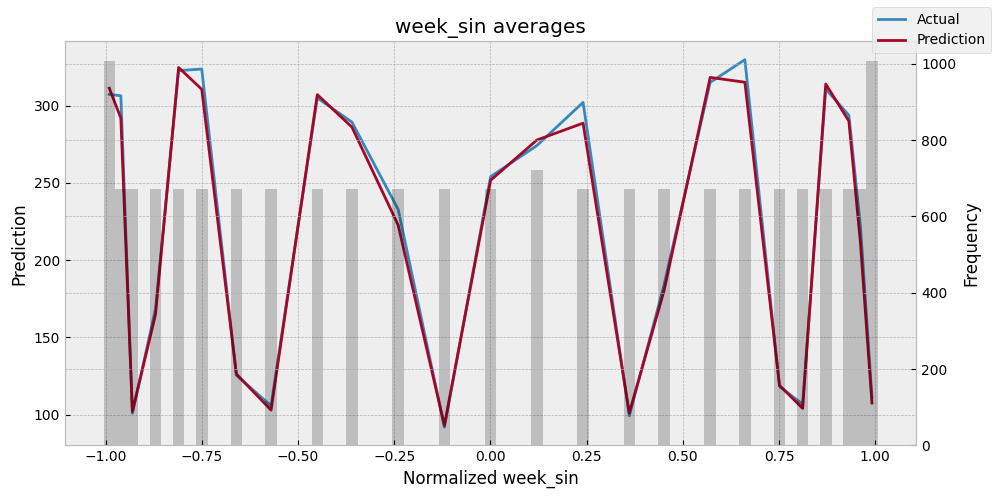

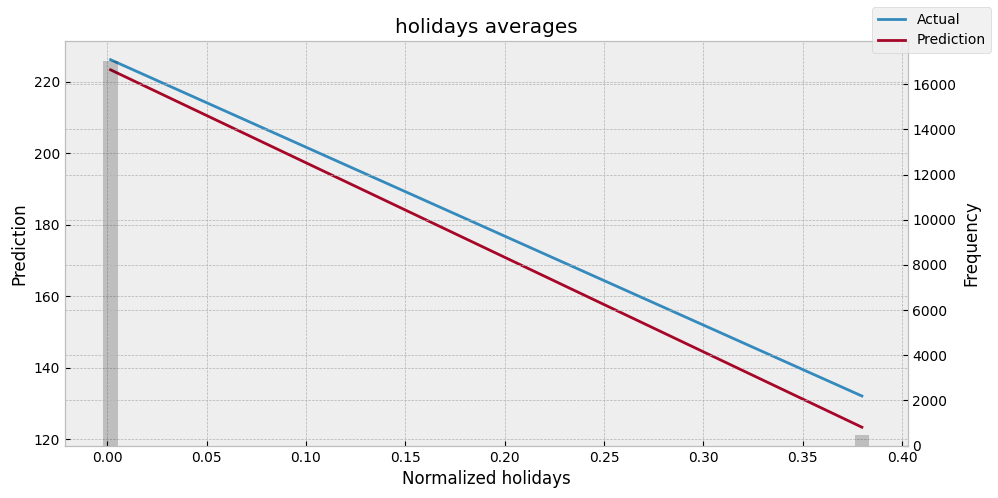

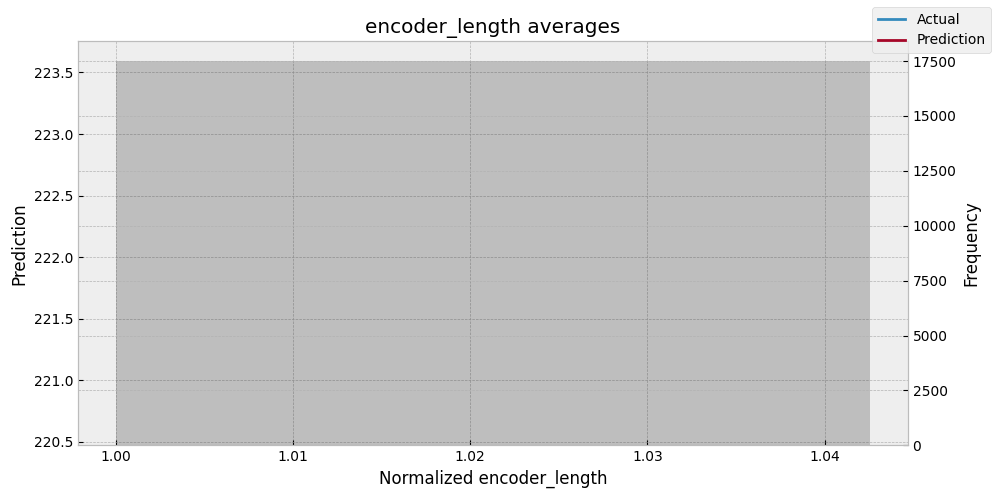

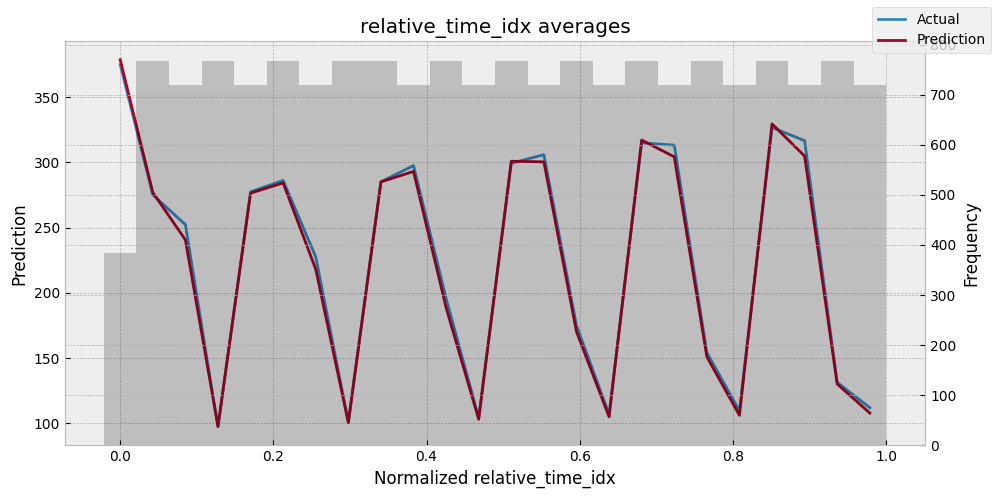

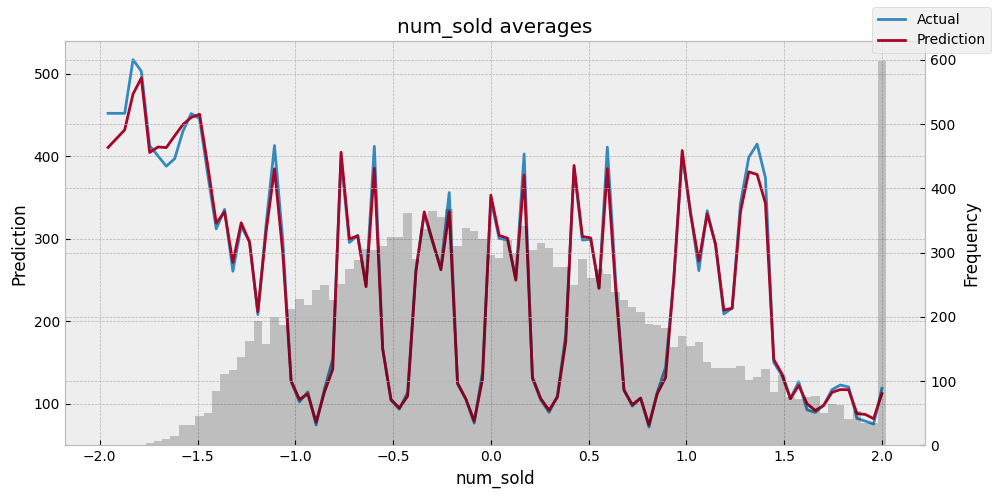

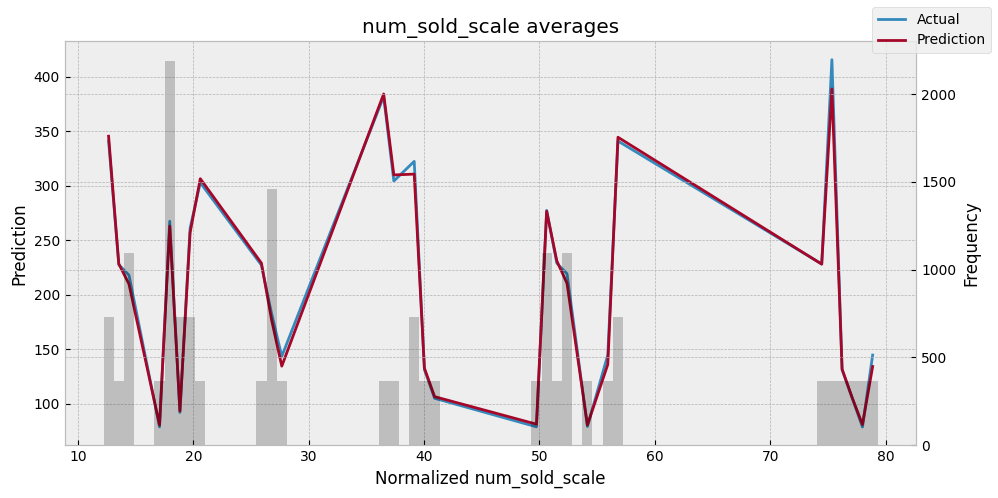

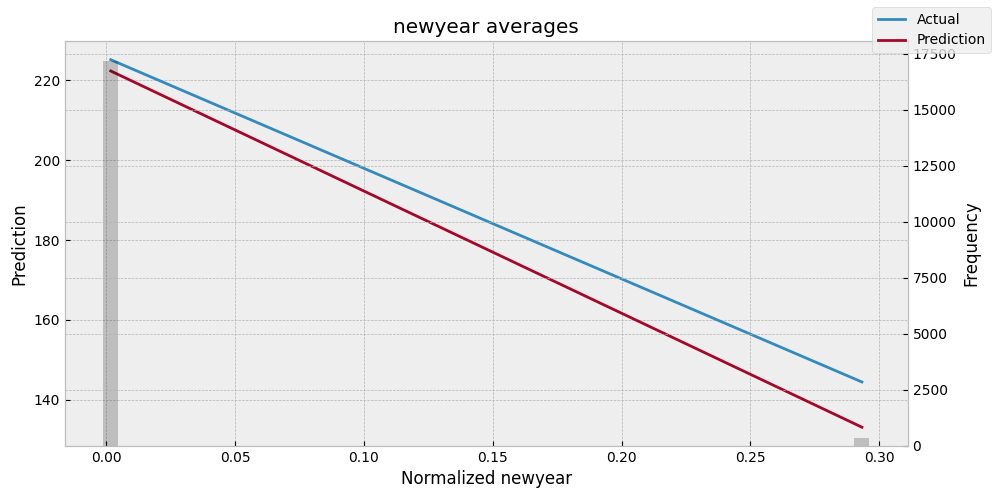

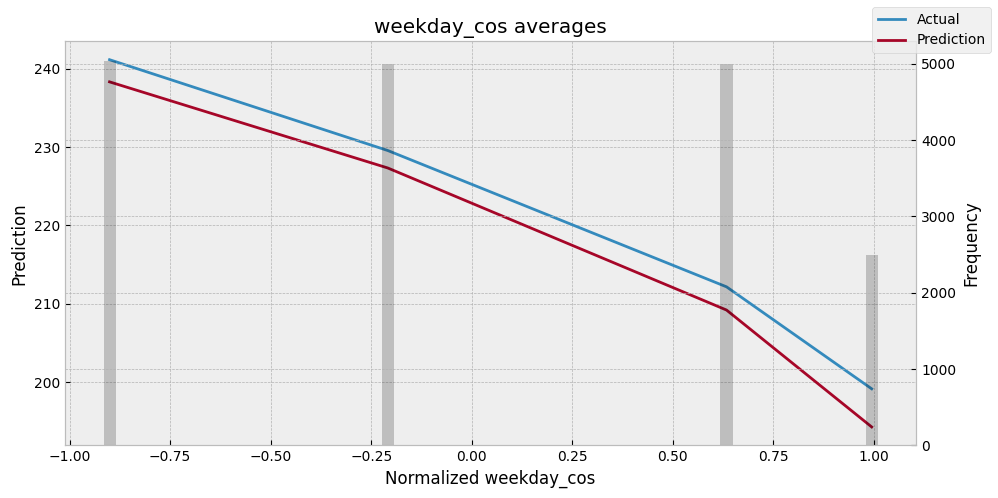

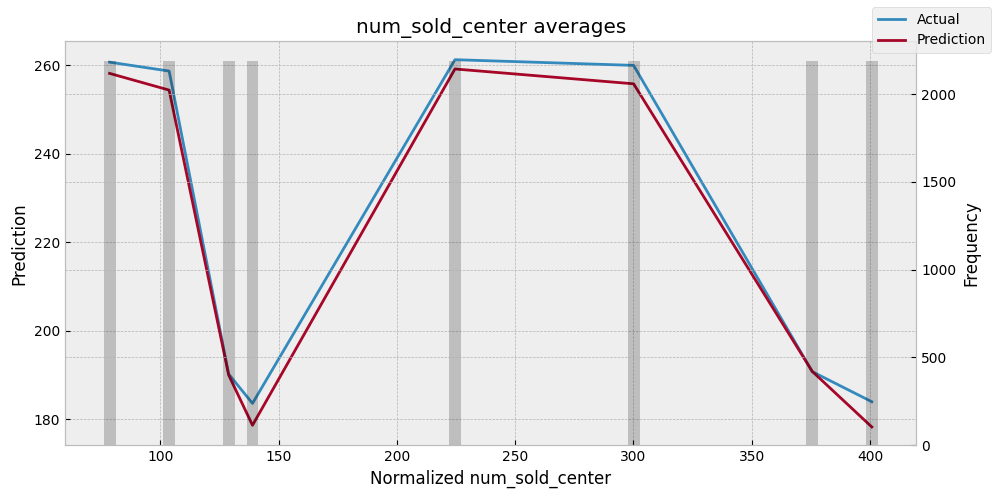

In [54]:
val_prediction_results = best_tft.predict(
    val_dataloader, 
    mode="prediction", # get only median predictions
    return_x=True,
    )
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_prediction_results.x, val_prediction_results.output)
features = list(set(predictions_vs_actuals['support'].keys())-set(['num_sold_lagged_by_365', 'num_sold_lagged_by_7']))
for feature in features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

In [55]:
val_prediction_results.keys()

('output', 'x', 'index', 'decoder_lengths', 'y')

In [89]:
# plot variable importance
interpretation = best_tft.interpret_output(val_prediction_results.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

IndexError: too many indices for tensor of dimension 2

## Inference

Now, we will infer the number of sales of 2021 for each individual time series. For this, we need to append the training dataset with static covariates and time-varying known values of 2021. In our case, this includes apriori known calendar features.

In [57]:
# add calendar features
test = add_cyclical_calendar_features(test_df.set_index("date"), features=["weekday", "week"])
test["weekend"] = (test.index.dayofweek > 4).astype(int)

/tmp/ipykernel_1675890/3552040668.py:46: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(df.index, feat)


In [58]:
# add holidays flag
holidays_dates_per_country = {}
for country in test["country"].unique():
    holidays_dates_per_country[country]=[tuple[0] for tuple in list(getattr(holidays, country)(years=set(test.index.year)).items())]
    test.loc[test["country"]==country, "holidays"]=test.loc[test["country"]==country].index.isin(holidays_dates_per_country[country])

test["holidays"] = test["holidays"].astype(int)

In [59]:
# add end-of-year holidays flag
test["newyear"]=0
for day in range(25,32):
    test.loc[(test.index.month == 12) & (test.index.day == day),"newyear"]=1

In [60]:
# Add required time_idx column w.r.t to last time index of training df
test = test.reset_index()
test = (test.merge((test[['date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['date']))
test["time_idx"]+=train["time_idx"].max()+1

In [61]:
# Drop unused columns
test = test.drop(["date", "row_id"], axis=1)

In [62]:
# Vertically stack the test df at the end of the training df
test = pd.concat([train, test], ignore_index=True).fillna(0.0)
test

country       store                           product    num_sold  \
0      Belgium  KaggleMart        Kaggle Advanced Techniques  623.047605   
1      Belgium  KaggleMart            Kaggle Getting Started  577.940086   
2      Belgium  KaggleMart                Kaggle Recipe Book  451.075189   
3      Belgium  KaggleMart  Kaggle for Kids: One Smart Goose  667.215384   
4      Belgium  KaggleRama        Kaggle Advanced Techniques  225.537595   
...        ...         ...                               ...         ...   
87643    Spain  KaggleMart  Kaggle for Kids: One Smart Goose    0.000000   
87644    Spain  KaggleRama        Kaggle Advanced Techniques    0.000000   
87645    Spain  KaggleRama            Kaggle Getting Started    0.000000   
87646    Spain  KaggleRama                Kaggle Recipe Book    0.000000   
87647    Spain  KaggleRama  Kaggle for Kids: One Smart Goose    0.000000   

       weekday_sin  weekday_cos      week_sin  week_cos  weekend  holidays  \
0        -0.781831     0.623490  6.432491e-16       1.0        1         1   
1        -0.781831     0.623490  6.432491e-16       1.0        1         1   
2        -0.781831     0.623490  6.432491e-16       1.0        1         1   
3        -0.781831     0.623490  6.432491e-16       1.0        1         1   
4        -0.781831     0.623490  6.432491e-16       1.0        1         1   
...            ...          ...           ...       ...      ...       ...   
87643    -0.433884    -0.900969  6.432491e-16       1.0        0         0   
87644    -0.433884    -0.900969  6.432491e-16       1.0        0         0   
87645    -0.433884    -0.900969  6.432491e-16       1.0        0         0   
87646    -0.433884    -0.900969  6.432491e-16       1.0        0         0   
87647    -0.433884    -0.900969  6.432491e-16       1.0        0         0   

       newyear    year  time_idx  
0            0  2017.0         0  
1            0  2017.0         0  
2            0  2017.0         0  
3            0  2017.0         0  
4            0  2017.0         0  
...        ...     ...       ...  
87643        1     0.0      1825  
87644        1     0.0      1825  
87645        1     0.0      1825  
87646        1     0.0      1825  
87647        1     0.0      1825  

[87648 rows x 13 columns]

In [63]:
# Create test dataset
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        test, 
                                        predict=True, 
                                        stop_randomization=True)

In [64]:
# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)


test_prediction_results = best_tft.predict(
    test_dataloader,
    mode="raw",
    return_index=True, # return the prediction index in the same order as the output
    return_x=True, # return network inputs in the same order as prediction output
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


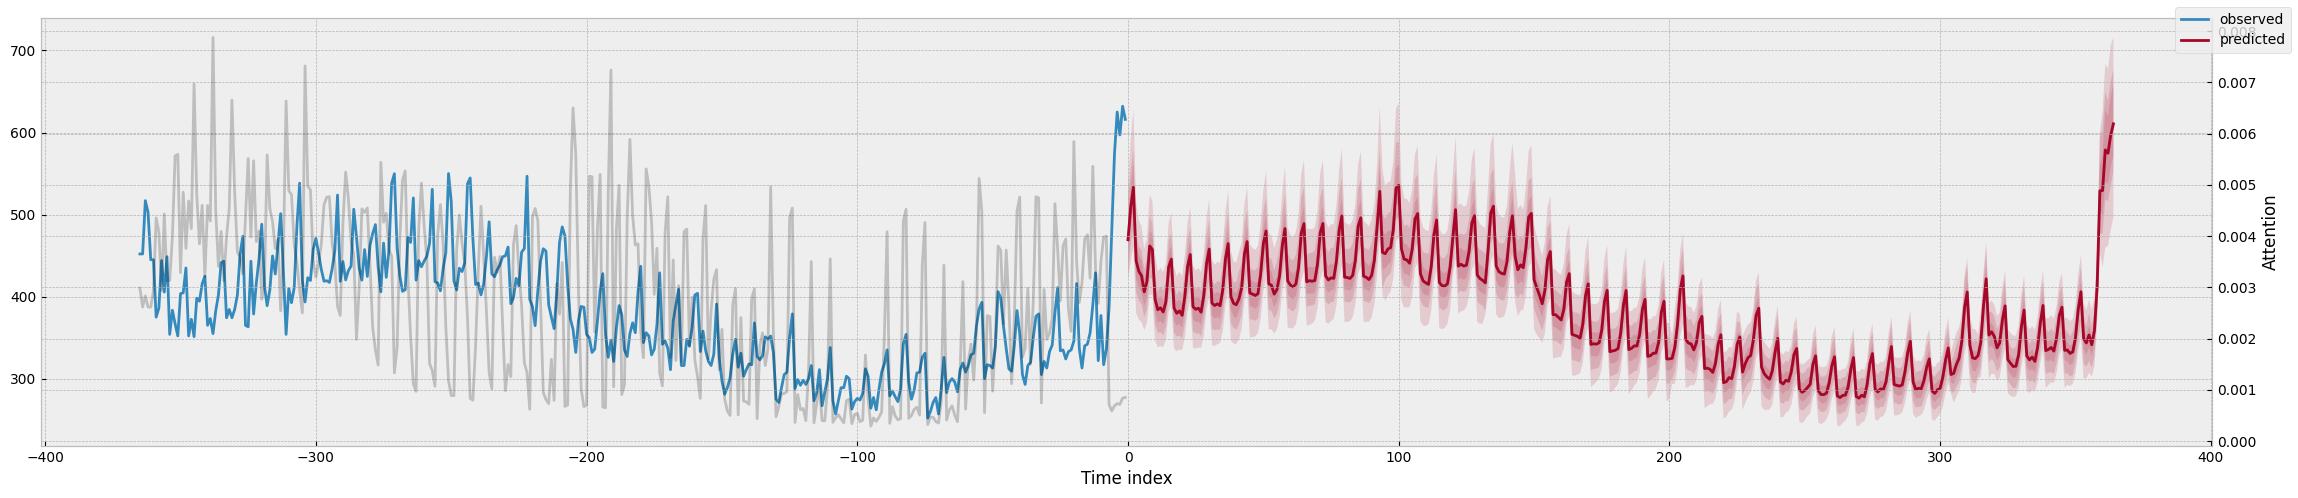

In [65]:
# Plot predictions for year 2021 and attention
# for idx in range(test_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(
        test_prediction_results.x, 
        test_prediction_results.output, 
        idx=idx, 
        show_future_observed=False,
        # add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
        ax=ax,
        )

In [66]:
test_prediction_results.keys()

('output', 'x', 'index', 'decoder_lengths', 'y')

## Submission

In [67]:
# detach predictions
test_prediction_results.output.prediction.cpu().numpy().shape

(48, 365, 7)

In [68]:
test_prediction_results.index.head()

time_idx  country       store                           product
0      1461  Belgium  KaggleMart        Kaggle Advanced Techniques
1      1461  Belgium  KaggleMart            Kaggle Getting Started
2      1461  Belgium  KaggleMart                Kaggle Recipe Book
3      1461  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4      1461  Belgium  KaggleRama        Kaggle Advanced Techniques

In [69]:
# Create predictions dataframe
predictions_df = test_df.copy()
predictions_df["num_sold"]=np.nan

# get 0.5 quantile (median) predictions
median_predictions = test_prediction_results.output.prediction.cpu().numpy()[:,:,4] 

# add sales predictions w.r.t to groups combination
for i, row in test_prediction_results.index.iterrows():
    predictions_df.loc[
        (predictions_df["country"]==row["country"]) & 
        (predictions_df["store"]==row["store"]) & 
        (predictions_df["product"]==row["product"]), 
        "num_sold"] = median_predictions[i]

In [70]:
predictions_df[["row_id", "num_sold"]].to_csv("./submission.csv", index=False)